# 1. Initial exploration

In [ ]:
pip install "git+https://github.com/greydanus/mnist1d.git@master"

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-_8l6zpbs
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-_8l6zpbs
  Resolved https://github.com/greydanus/mnist1d.git to commit 2e170ccfa70f37ce07e2df14d6bad2906a1c2d4b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


--2024-05-16 04:08:16--  https://www.stats.ox.ac.uk/pub/PRNN/crabs.dat
Resolving www.stats.ox.ac.uk (www.stats.ox.ac.uk)... 163.1.210.36
Connecting to www.stats.ox.ac.uk (www.stats.ox.ac.uk)|163.1.210.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6429 (6.3K)
Saving to: ‘crabs.dat’

crabs.dat           100%[===================>]   6.28K  --.-KB/s    in 0s      

2024-05-16 04:08:16 (1.28 GB/s) - ‘crabs.dat’ saved [6429/6429]



In [ ]:
# Check if JAX is using the GPU
from jax.lib import xla_bridge
if xla_bridge.get_backend().platform != "gpu":
    raise ValueError("Not using the GPU")

ValueError: Not using the GPU

In [ ]:
from mnist1d.data import make_dataset, get_dataset_args

defaults = get_dataset_args()
data = make_dataset(defaults)
x,y,t = data['x'], data['y'], data['t']

x.shape, y.shape, t.shape

((4000, 40), (4000,), (40,))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

from typing import Callable
from typing_extensions import Annotated
import numpy as np
from scipy.spatial.distance import pdist, squareform

from pydantic import (
    BaseModel,
    conint,
    confloat,
    Field,
    field_validator,
    BeforeValidator,
    ConfigDict,
    PlainSerializer
)


from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Clustering pipeline/comparison
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


import jax.numpy as jnp


def nd_array_custom_before_validator(x):
    # custome before validation logic
    return x


def nd_array_custom_serializer(x):
    # custome serialization logic
    return str(x)
# From https://github.com/pydantic/pydantic/issues/7017
NdArray = Annotated[
    np.ndarray,
    BeforeValidator(nd_array_custom_before_validator),
    PlainSerializer(nd_array_custom_serializer, return_type=str),
]

class GraphParams(BaseModel):
    data: NdArray
    epsilon: confloat(gt=0) = None  # greater than 0, optional for epsilon graph
    k: conint(gt=0) = None  # greater than 0, optional for k-NN graphs
    sigma: confloat(gt=0) = 1.0  # greater than 0, default for Gaussian similarity
    model_config = ConfigDict(arbitrary_types_allowed=True)

    @field_validator('data')
    @classmethod
    def check_data(cls, v):
        if v.ndim != 2:
            raise ValueError("Data must be a 2-dimensional array")
        return v


def eps_similarity(x):
    data = jnp.asarray(x)
    # Calculate distances
    distances = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)

    epsilon = jnp.quantile(jnp.ravel(distances), q=0.02)

    similarity = (distances <= epsilon).astype('float64')
    # Sort the adjacency matrx by rows and record the indices

    # Sum rows
    degrees = jnp.diag(similarity.sum(axis=0))

    laplacian = degrees - similarity

    return laplacian

def get_laplacian_features(laplacian, k=5):

    lambdas, eigen_vectors = jnp.linalg.eig(laplacian)

    sorted_indices = jnp.argsort(np.abs(lambdas))

    selected_features = jnp.real(eigen_vectors[:, sorted_indices[1:k]])
    return selected_features

from sklearn.cluster import KMeans

def create_laplacian(x):
    data = jnp.asarray(x)
    # Calculate euclidean distances
    distances = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)
    # Epsilon estimation can be improved
    epsilon = jnp.quantile(jnp.ravel(distances), q=epsilon)

    similarity = (distances <= epsilon).astype('float64')
    # Sort the adjacency matrx by rows and record the indices

    # Sum rows
    degrees = jnp.diag(similarity.sum(axis=0))

    laplacian = degrees - similarity

    # Normalized transition matrix, each row sums to 1
    laplacian_random_walk = jnp.diag(1 / jnp.diag(degrees)) @ laplacian

    return laplacian_random_walk

def simple_spectral_clustering(x, K: int=10, epsilon=0.05):
    """
    Args:
        x : data
        K (int): number of cluster
    """
    data = jnp.asarray(x)
    # Calculate euclidean distances
    distances = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)
    # Epsilon estimation can be improved
    epsilon = jnp.quantile(jnp.ravel(distances), q=epsilon)

    similarity = (distances <= epsilon).astype('float64')
    # Sort the adjacency matrx by rows and record the indices

    # Sum rows
    degrees = jnp.diag(similarity.sum(axis=0))

    laplacian = degrees - similarity

    # Normalized transition matrix, each row sums to 1
    laplacian_random_walk = jnp.diag(1 / jnp.diag(degrees)) @ laplacian

    # Eigen-Value decomposition

    lambdas, eigen_vectors = np.linalg.eig(laplacian)

    sorted_indices = np.argsort(np.abs(lambdas))
    # Discarg first eigen-vector
    selected_features = np.real(eigen_vectors[:, sorted_indices[1:K+1]])

    print(f"{selected_features.shape=}")
    print(selected_features[:10,:])

    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(selected_features)

    return kmeans


def plot_clustering(X, cluster_pred):
    colors = np.array(list(islice(cycle(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]), int(max(cluster_pred) + 1))))
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[cluster_pred])


def mnist1d_performance_evaluation(y_true=None, y_pred=None):
    if y_true is not None:

        rand_score = metrics.rand_score(y_true, y_pred)
        adjusted_rand_score = metrics.adjusted_rand_score(y_true, y_pred)
        adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y_true, y_pred)

        print(f"{rand_score=}")
        print(f"{adjusted_rand_score=}")
        print(f"{adjusted_mutual_info_score=}")


        data = metrics.confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        plt.figure(figsize = (8,8))
        sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 12})
        plt.plot()


params = GraphParams(
    data=x,
    k=4
)


In [ ]:
# Example of random walk laplacian
data = jnp.asarray(params.data)

sigma = 0.1
#
W = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)

S = jnp.exp(-W*W / (2 * sigma**2))

# Sum rows
D = jnp.diag(S.sum(axis=0))

L = D - W

L_rw = jnp.diag(1 / jnp.diag(D)) @ S

## Sample Distribution of similarity for one row, class 2 (the correct class) is shifted to the right, but still has mayor overlap with otherclass

y[0]=2


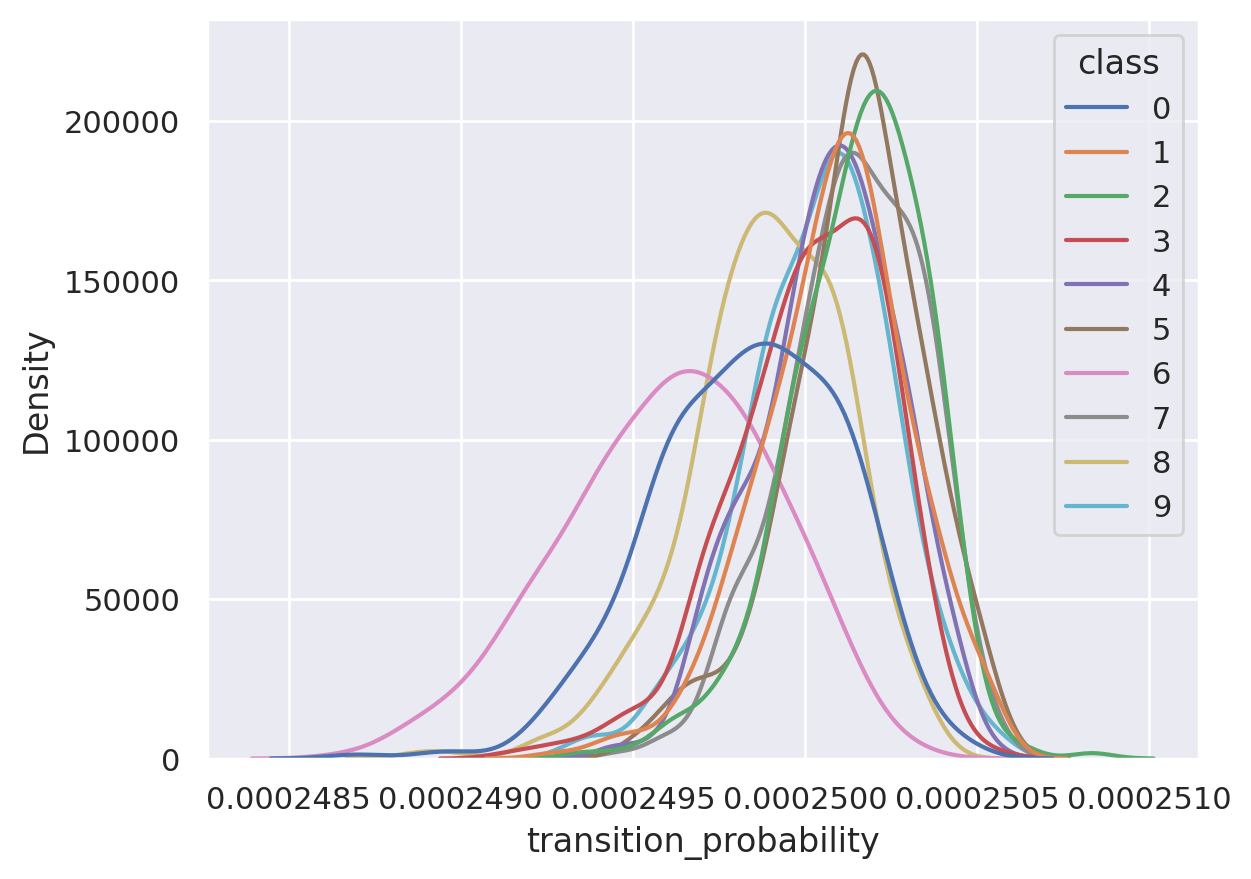

In [ ]:
import pandas as pd
df_random_walk = pd.DataFrame()
df_random_walk["transition_probability"] = L_rw[0]
df_random_walk["class"] = y
print(f"{y[0]=}")
_ = sns.kdeplot(data=df_random_walk, x="transition_probability", hue="class", palette=sns.color_palette())

rand_score=0.8272198049512378
adjusted_rand_score=0.0531191353044402
adjusted_mutual_info_score=0.12283901429650469


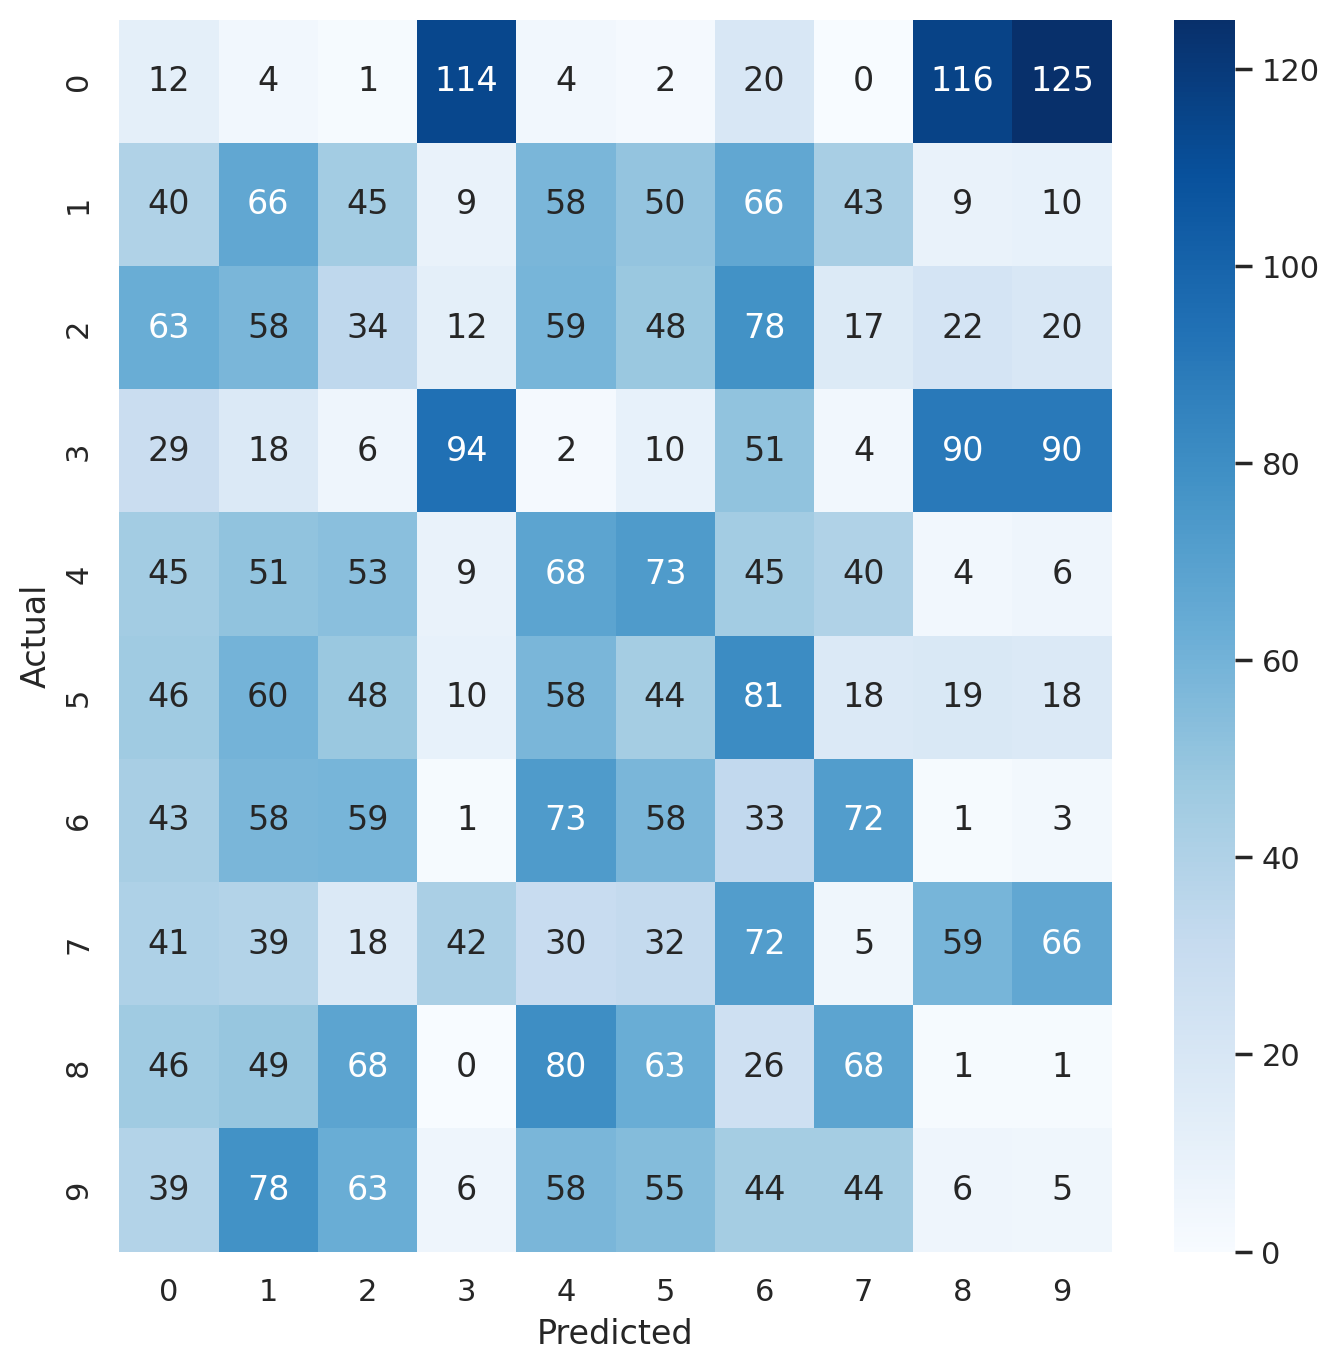

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA()
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0).fit(x)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("kmeans", kmeans)])

model = pipe.fit(x)

model = model.named_steps["kmeans"]

mnist1d_performance_evaluation(y_true=y, y_pred=model.labels_)

## Simplest k-means on 1D-MNIST

rand_score=0.8235171292823206
adjusted_rand_score=0.052732759439443534
adjusted_mutual_info_score=0.12918930034920573


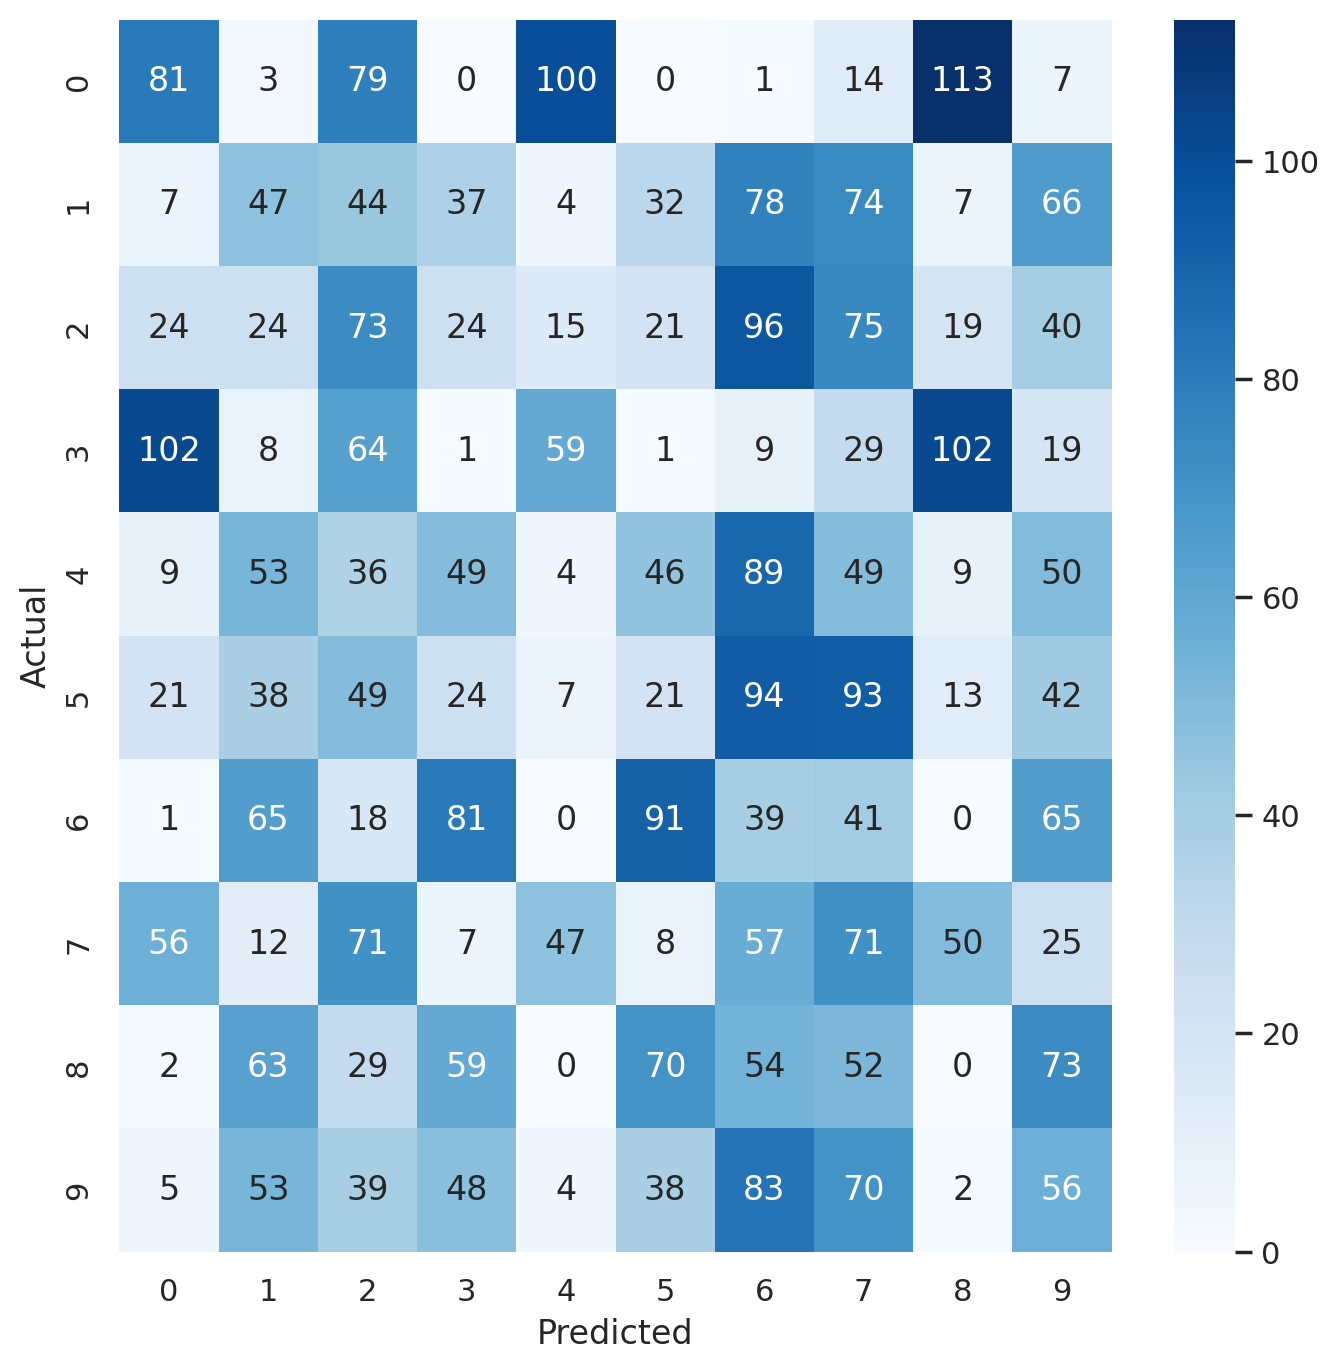

In [ ]:
model = KMeans(n_clusters=10, init='k-means++', random_state=0).fit(x)
mnist1d_performance_evaluation(y_true=y, y_pred=model.labels_)

## Our spectral clustering doesn't work on 1d-mnist

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


selected_features.shape=(4000, 10)
[[ 0.          0.          0.         ...  0.00027868 -0.00020877
  -0.0002188 ]
 [ 0.          0.          0.         ...  0.00037806 -0.0002851
  -0.00030108]
 [ 0.          0.          0.         ...  0.0002599  -0.00020671
  -0.00021203]
 ...
 [ 0.          0.          0.         ...  0.00027338 -0.00020624
  -0.00021883]
 [ 0.          0.          0.         ...  0.00025798 -0.00020635
  -0.0002198 ]
 [ 0.          0.          0.         ...  0.00031457 -0.00023655
  -0.00024878]]
rand_score=0.1033875968992248
adjusted_rand_score=-8.500627941060347e-07
adjusted_mutual_info_score=-1.7841507604654932e-06


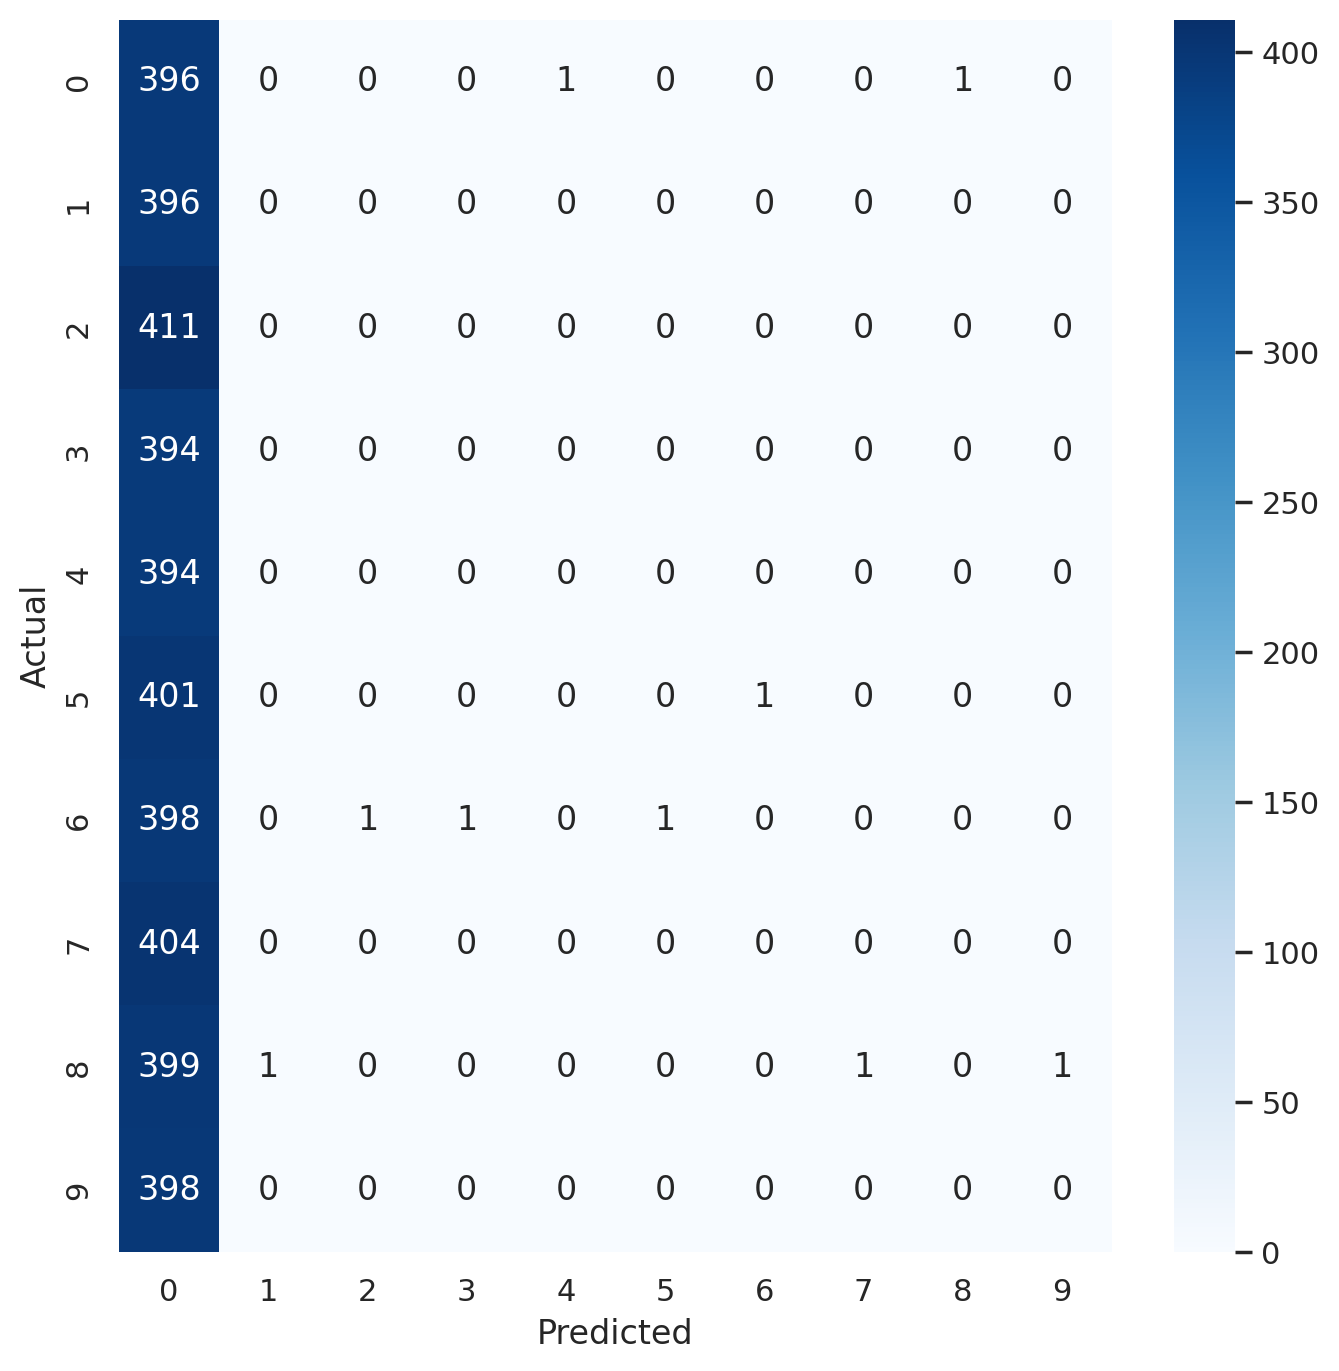

In [ ]:
model = simple_spectral_clustering(x, K=10)
mnist1d_performance_evaluation(y_true=y, y_pred=model.labels_)

## Epsilon-similarity and our implementation works on moons

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


selected_features.shape=(500, 2)
[[-4.5086461e-04 -3.5164647e-18]
 [-4.5086461e-04 -7.2824192e-16]
 [-4.5086461e-04 -1.5435280e-16]
 [ 6.3243948e-02  8.8715546e-02]
 [-4.5086461e-04 -3.7916338e-17]
 [-4.5086461e-04  1.3408430e-16]
 [ 6.3243948e-02 -8.5078366e-02]
 [ 6.3243948e-02  8.6922124e-02]
 [ 6.3243948e-02  8.3440751e-02]
 [-4.5086461e-04 -1.4375687e-16]]


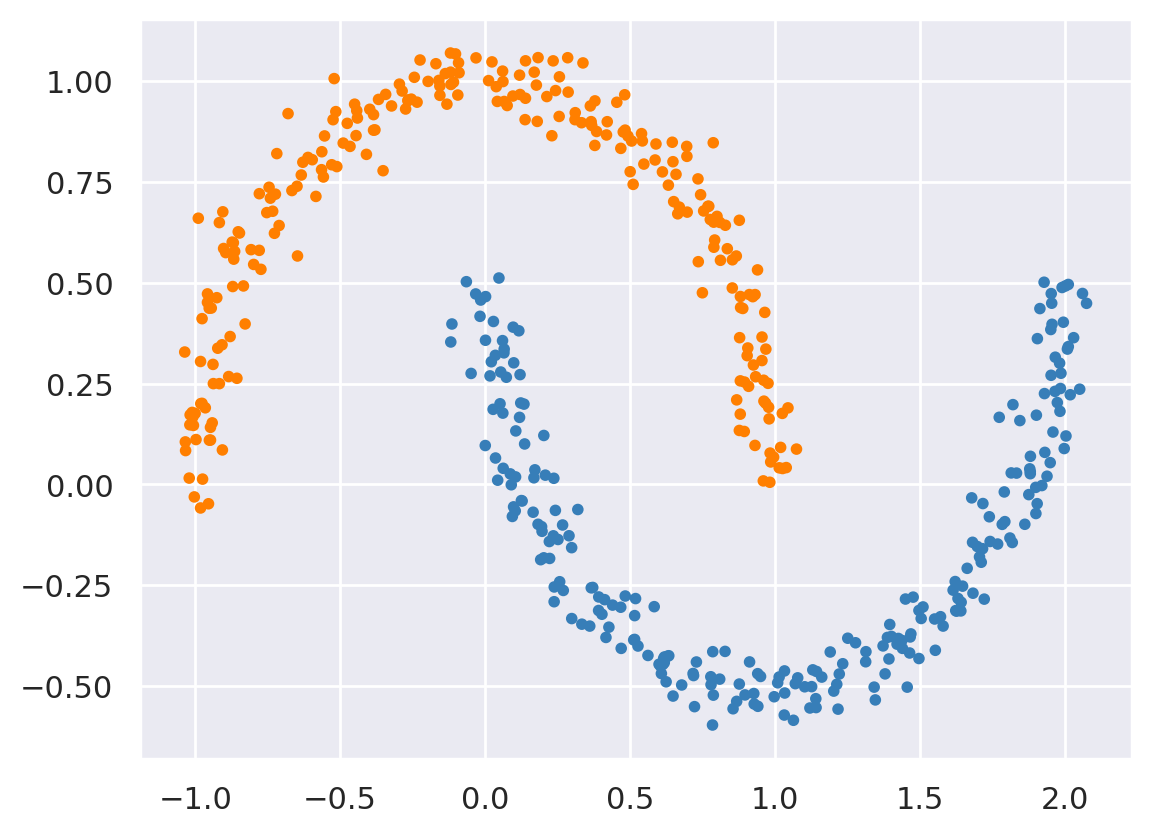

In [ ]:
model = simple_spectral_clustering(X_moons, K=2)
plot_clustering(X_moons, model.labels_)

## Sklearn Spectral Clustering

rand_score=0.6571831707926982
adjusted_rand_score=0.046075171090671586
adjusted_mutual_info_score=0.23330786237616633


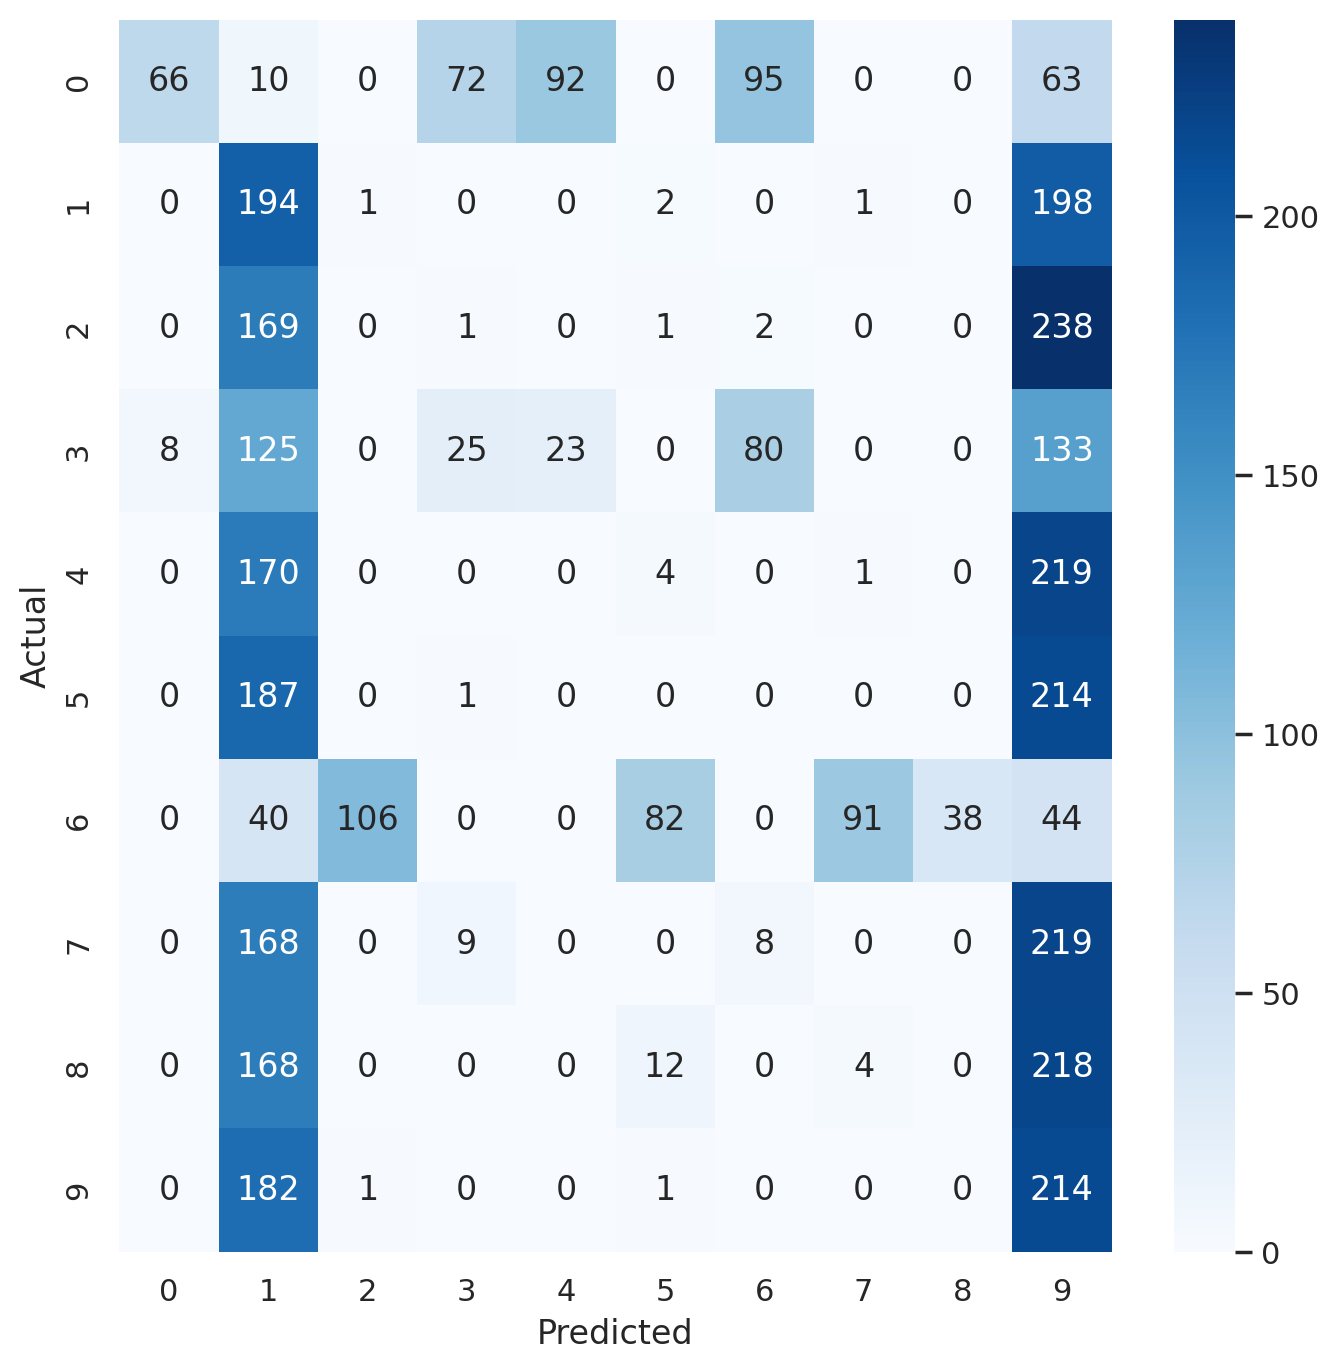

In [ ]:
model = cluster.SpectralClustering(n_clusters=10, eigen_solver="arpack", affinity="nearest_neighbors", random_state=42)
model.fit(x)
mnist1d_performance_evaluation(y_true=y, y_pred=model.labels_)

In [ ]:
def cluster_data(X, y, plot=True):
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    n_clusters = 2

    # Clustering algorithms with individual parameters
    clustering_algorithms = {
        "MiniBatch KMeans": {
            "algorithm": cluster.MiniBatchKMeans(n_clusters=n_clusters, random_state=42),
            "params": {}
        },
        "Spectral Clustering": {
            "algorithm": cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver="arpack", affinity="nearest_neighbors", random_state=42),
            "params": {"n_neighbors": 3}
        },
        "DBSCAN": {
            "algorithm": cluster.DBSCAN(eps=0.3),
            "params": {}
        },
        "Gaussian Mixture": {
            "algorithm": mixture.GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42),
            "params": {}
        }
    }

    if plot:
        plt.figure(figsize=(12, len(clustering_algorithms) * 3))
        plt.tight_layout()

    # Execute clustering for each algorithm
    for idx, (name, details) in enumerate(clustering_algorithms.items(), start=1):
        t0 = time.time()
        params = details.get("params", {})

        # Handle special parameters like bandwidth and connectivity
        if "quantile" in details["params"]:
            bandwidth = cluster.estimate_bandwidth(X, quantile=details["params"]["quantile"])
            details["algorithm"].set_params(bandwidth=bandwidth)
        if name in ["Ward"]:
            connectivity = kneighbors_graph(X, n_neighbors=details["params"]["n_neighbors"], include_self=False)
            connectivity = 0.5 * (connectivity + connectivity.T)
            details["algorithm"].set_params(connectivity=connectivity)

        # Catch warnings related to graph connectivity
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            details["algorithm"].fit(X)

        t1 = time.time()
        if hasattr(details["algorithm"], 'labels_'):
            y_pred = details["algorithm"].labels_.astype(int)
        else:
            y_pred = details["algorithm"].predict(X)

        if plot:
            plt.subplot(len(clustering_algorithms), 1, idx)
            plt.title(name, size=18)
            colors = np.array(list(islice(cycle(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]), int(max(y_pred) + 1))))
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.text(0.99, 0.01, ("%.2fs" % (t1 - t0)).lstrip("0"), transform=plt.gca().transAxes, size=15, horizontalalignment="right")

    if plot:
        plt.show()


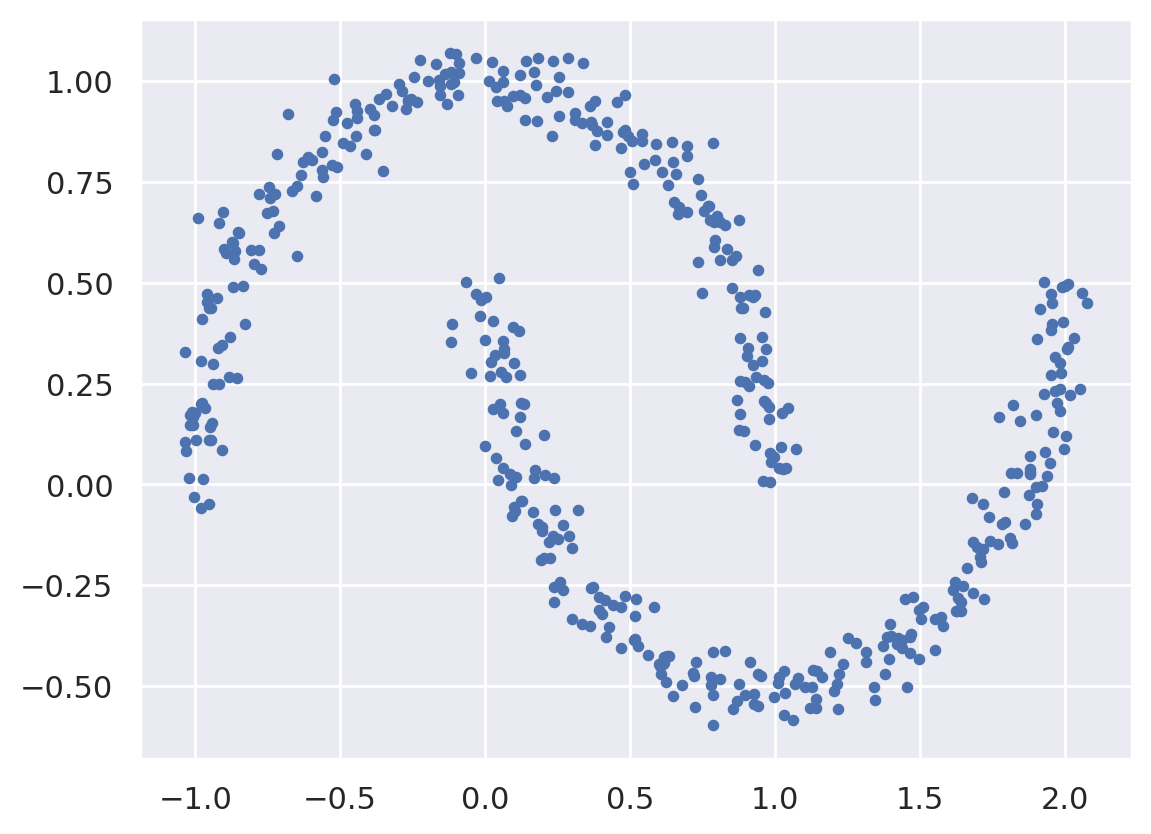

In [ ]:
from sklearn import cluster, datasets, mixture

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
X_moons, y_moons = noisy_moons

plt.scatter(X_moons[:,0], X_moons[:,1], s=10)

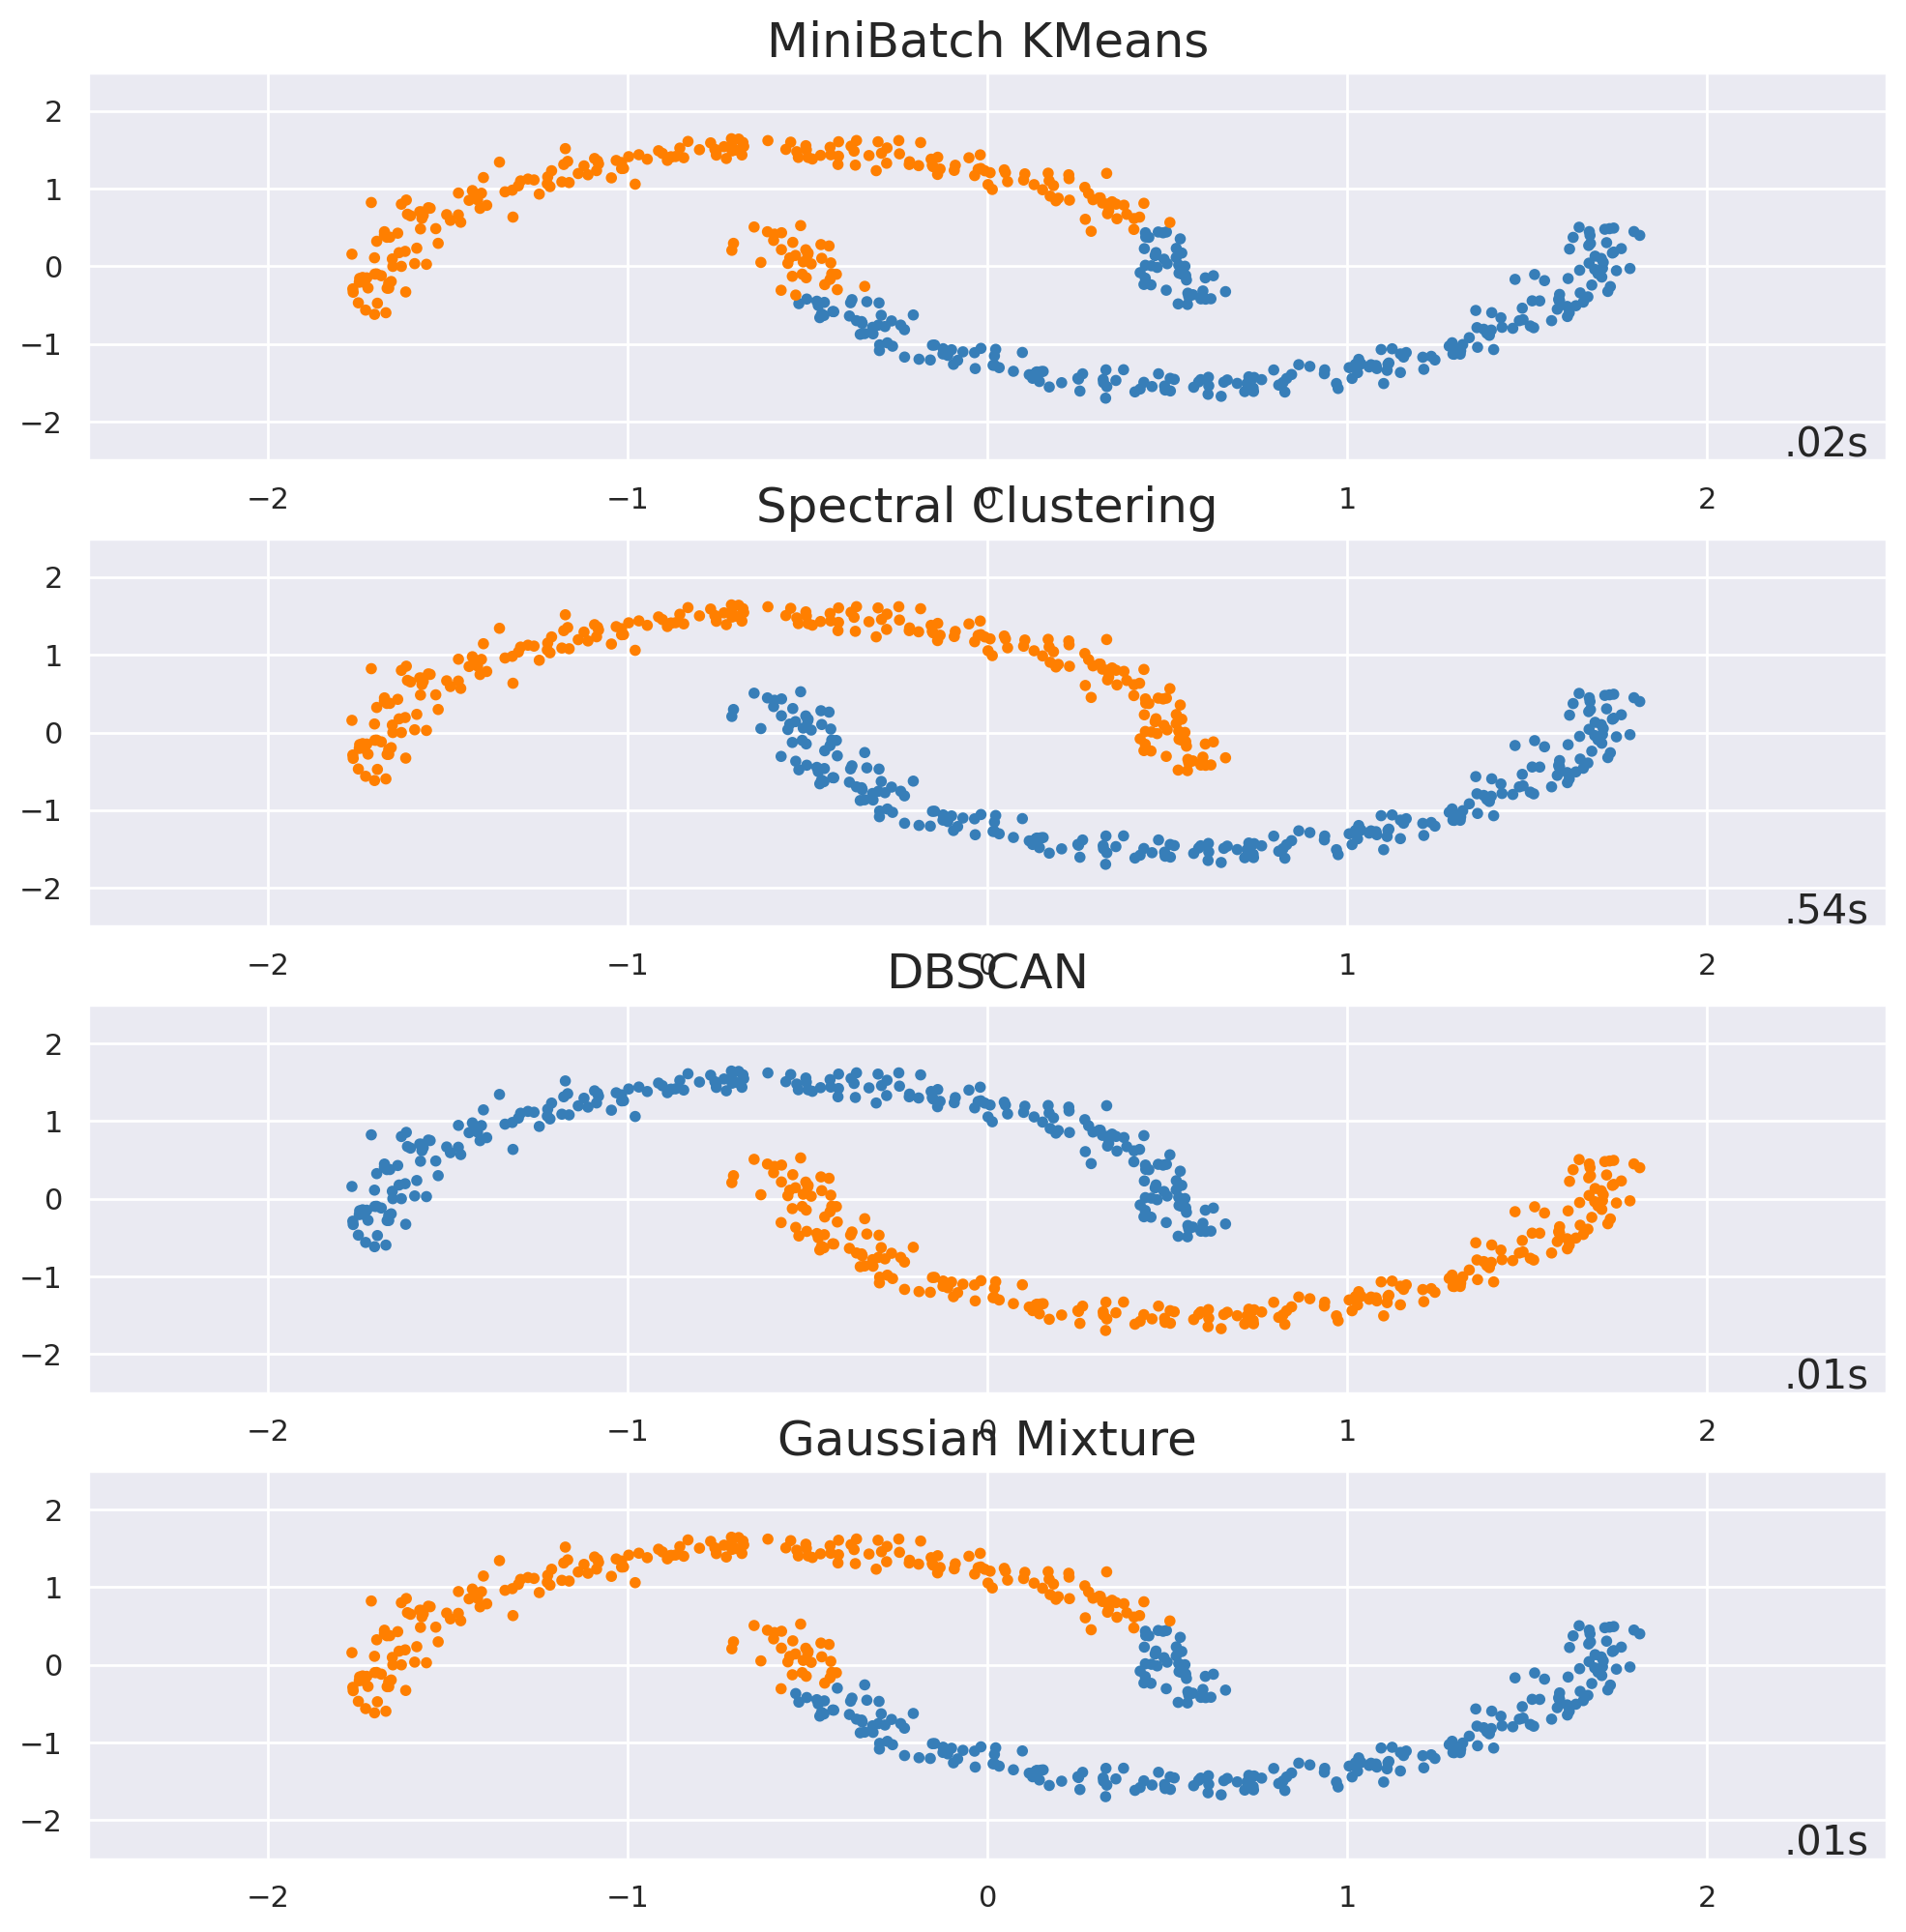

In [ ]:
cluster_data(X_moons, y_moons)

[[ 1.00987563  0.05437942]
 [ 0.98087064  0.1617556 ]
 [ 0.24681711 -0.17669733]
 ...
 [ 1.77944611 -0.01760843]
 [-0.81111067  0.77917769]
 [-0.07948662  1.035939  ]]


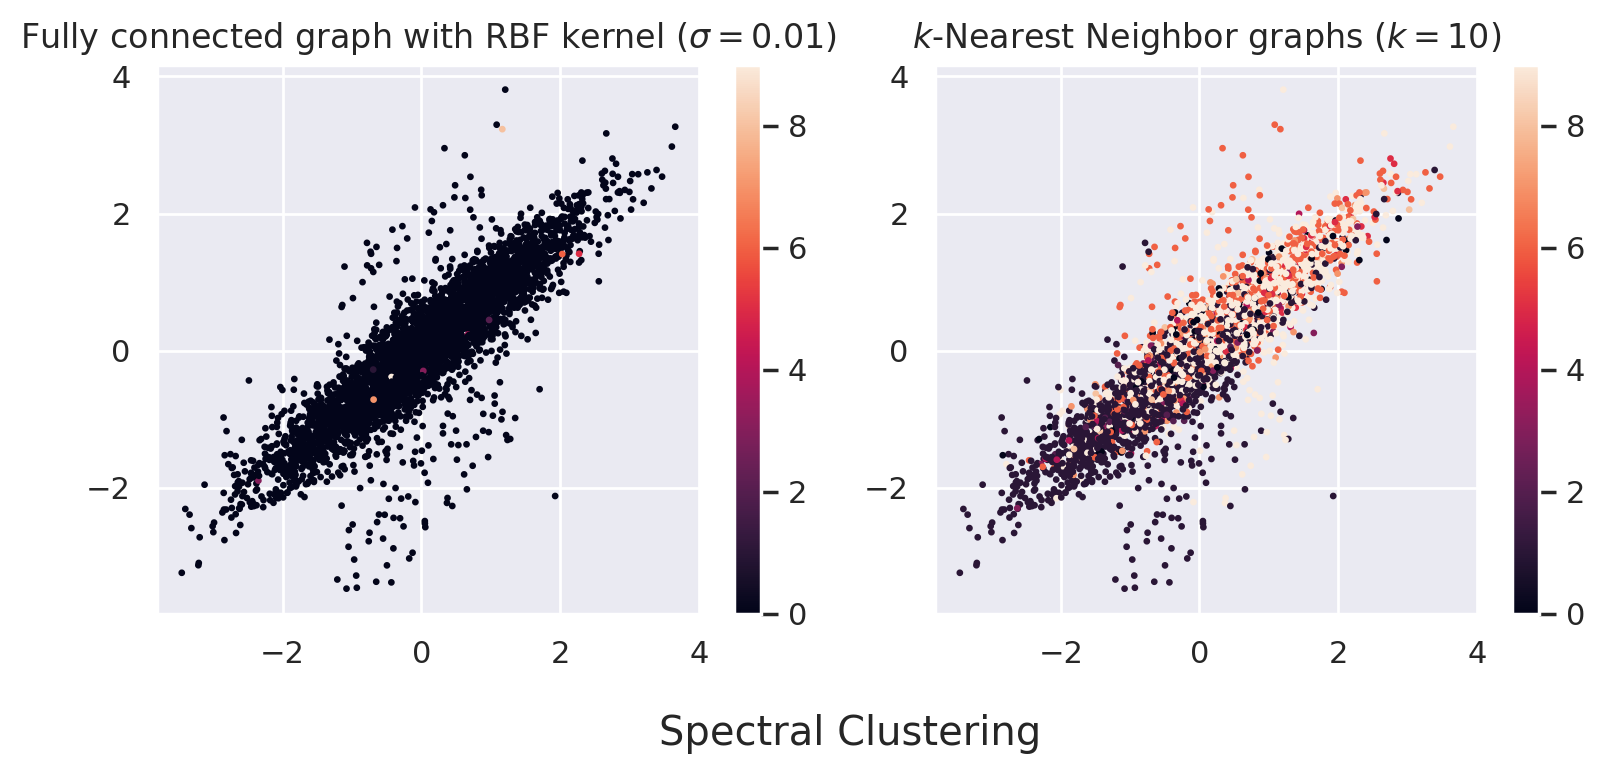

In [ ]:
# https://github.com/zhangyk8/Spectral-Clustering/blob/master/spectral_clustering.py
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

# Based on "A Tutorial on Spectral Clustering" written by Ulrike von Luxburg
def Spectral_Clustering(X, K=8, adj=True, metric='euclidean', sim_graph='fully_connect', sigma=1, knn=10, epsi=0.5, normalized=1):
    '''
    Input:
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: True;
        metric: string, A parameter passing to "scipy.spatial.distance.pdist()" function for computing the adjacency matrix (deprecated if adj=True). Default: 'euclidean';
        sim_graph: string, Specifying the type of similarity graphs. Choices are ['fully_connect', 'eps_neighbor', 'knn', 'mutual_knn']. Default: 'fully_connect';
        sigma: float, The variance for the Gaussian (aka RBF) kernel (Used when sim_graph='fully_connect'). Default: 1;
        knn: int, The number of neighbors used to construct k-Nearest Neighbor graphs (Used when sim_graph='knn' or 'mutual_knn'). Default: 10;
        epsi: float, A parameter controlling the connections between points (Used when sim_graph='eps_neighbor'). Default: 0.5;
        normalized: int, 1: Random Walk normalized version; 2: Graph cut normalized version; other integer values: Unnormalized version. Default: 1.
    Output:
        sklearn.cluster class, Attributes:
            cluster_centers_ : array, [n_clusters, n_features], Coordinates of cluster centers in K-means;
            labels_ : Labels of each point;
            inertia_ : float, Sum of squared distances of samples to their closest cluster center in K-means;
            n_iter_ : int, Number of iterations run in K-means.
    '''
    # Compute the adjacency matrix
    if not adj:
        Adj_mat = squareform(pdist(X, metric=metric))
    else:
        Adj_mat = X
    # Compute the weighted adjacency matrix based on the type of similarity graphs
    if sim_graph ==  'fully_connect':
        W = np.exp(-Adj_mat/(2*sigma))
    elif sim_graph == 'eps_neighbor':
        W = (Adj_mat <= epsi).astype('float64')
    elif sim_graph == 'knn':
        W = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight (i,j) to 1 when either i or j is within the k-nearest neighbors of each other
        for i in range(Adj_sort.shape[0]):
            W[i,Adj_sort[i,:][:(knn+1)]] = 1
    elif sim_graph == 'mutual_knn':
        W1 = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight W1[i,j] to 0.5 when either i or j is within the k-nearest neighbors of each other (Flag)
        # Set the weight W1[i,j] to 1 when both i and j are within the k-nearest neighbors of each other
        for i in range(Adj_mat.shape[0]):
            for j in Adj_sort[i,:][:(knn+1)]:
                if i == j:
                    W1[i,i] = 1
                elif W1[i,j] == 0 and W1[j,i] == 0:
                    W1[i,j] = 0.5
                else:
                    W1[i,j] = W1[j,i] = 1
        W = np.copy((W1 > 0.5).astype('float64'))
    else:
        raise ValueError("The 'sim_graph' argument should be one of the strings, 'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'!")

    # Compute the degree matrix and the unnormalized graph Laplacian
    D = np.diag(np.sum(W, axis=1))
    L = D - W

    # Compute the matrix with the first K eigenvectors as columns based on the normalized type of L
    if normalized == 1:   ## Random Walk normalized version
        # Compute the inverse of the diagonal matrix
        D_inv = np.diag(1/np.diag(D))
        # Compute the eigenpairs of L_{rw}
        Lambdas, V = np.linalg.eig(np.dot(D_inv, L))
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
    elif normalized == 2:   ## Graph cut normalized version
        # Compute the square root of the inverse of the diagonal matrix
        D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
        # Compute the eigenpairs of L_{sym}
        Lambdas, V = np.linalg.eig(np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt))
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        if any(V_K.sum(axis=1) == 0):
            raise ValueError("Can't normalize the matrix with the first K eigenvectors as columns! Perhaps the number of clusters K or the number of neighbors in k-NN is too small.")
        # Normalize the row sums to have norm 1
        V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))
    else:   ## Unnormalized version
        # Compute the eigenpairs of L
        Lambdas, V = np.linalg.eig(L)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])

    # Conduct K-Means on the matrix with the first K eigenvectors as columns
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)
    return kmeans


def main():
    # Generate a toy dataset...
    moon_data, moon_labels = make_moons(1000, noise=0.05)
    # Compute the adjacency matrix
    print(moon_data)
    moon_data = x
    Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
    K = 10
    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat, K=K, sim_graph='fully_connect', sigma=0.01, normalized=1)
    spec_re2 = Spectral_Clustering(Adj_mat, K=K, sim_graph='knn', knn=10, normalized=1)

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')

    plt.subplot(1, 2, 2)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re2.labels_, s=2)
    plt.colorbar()
    plt.title('$k$-Nearest Neighbor graphs ($k=10$)')

    plt.suptitle('Spectral Clustering', y=-0.01)

    # Automatrically adjust padding between subpots
    plt.tight_layout()
    plt.show()




# 2. Grid of dimensionality reduction and clustering

In [1]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00


In [2]:
import umap
reducer = umap.UMAP()

In [3]:
!wget https://www.stats.ox.ac.uk/pub/PRNN/crabs.dat

import pandas as pd

crabs = pd.read_csv("crabs.dat", sep='\s+')
crabs

--2024-05-17 16:09:15--  https://www.stats.ox.ac.uk/pub/PRNN/crabs.dat
Resolving www.stats.ox.ac.uk (www.stats.ox.ac.uk)... 163.1.210.36
Connecting to www.stats.ox.ac.uk (www.stats.ox.ac.uk)|163.1.210.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6429 (6.3K)
Saving to: ‘crabs.dat’

crabs.dat           100%[===================>]   6.28K  --.-KB/s    in 0s      

2024-05-17 16:09:15 (1.03 GB/s) - ‘crabs.dat’ saved [6429/6429]



sp sex  index    FL    RW    CL    CW    BD
0    B   M      1   8.1   6.7  16.1  19.0   7.0
1    B   M      2   8.8   7.7  18.1  20.8   7.4
2    B   M      3   9.2   7.8  19.0  22.4   7.7
3    B   M      4   9.6   7.9  20.1  23.1   8.2
4    B   M      5   9.8   8.0  20.3  23.0   8.2
..  ..  ..    ...   ...   ...   ...   ...   ...
195  O   F     46  21.4  18.0  41.2  46.2  18.7
196  O   F     47  21.7  17.1  41.7  47.2  19.6
197  O   F     48  21.9  17.2  42.6  47.4  19.5
198  O   F     49  22.5  17.2  43.0  48.7  19.8
199  O   F     50  23.1  20.2  46.2  52.5  21.1

[200 rows x 8 columns]

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': None, 'standardize': True}
adjusted_rand_score=0.02068482350527869 adjusted_mutual_info_score=0.03542274446944491


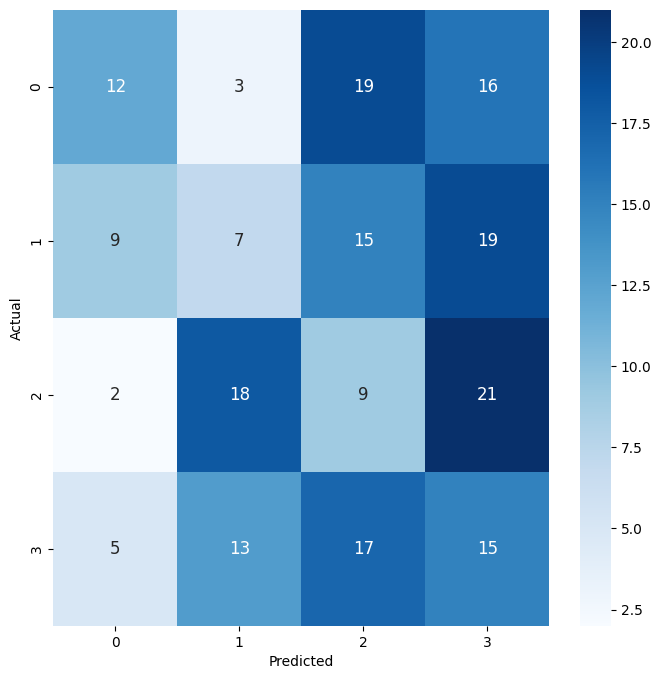

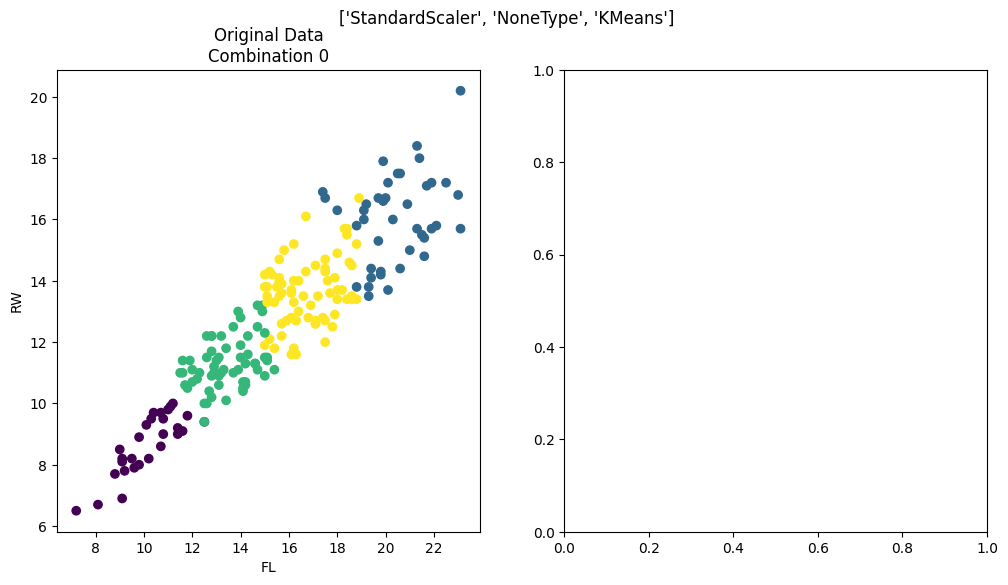

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': None, 'standardize': False}
adjusted_rand_score=0.01573616840753068 adjusted_mutual_info_score=0.03413401623539328


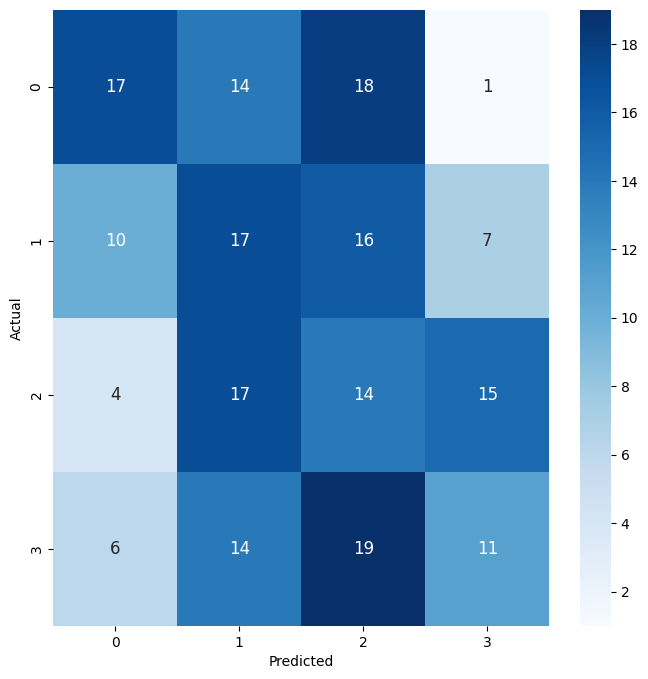

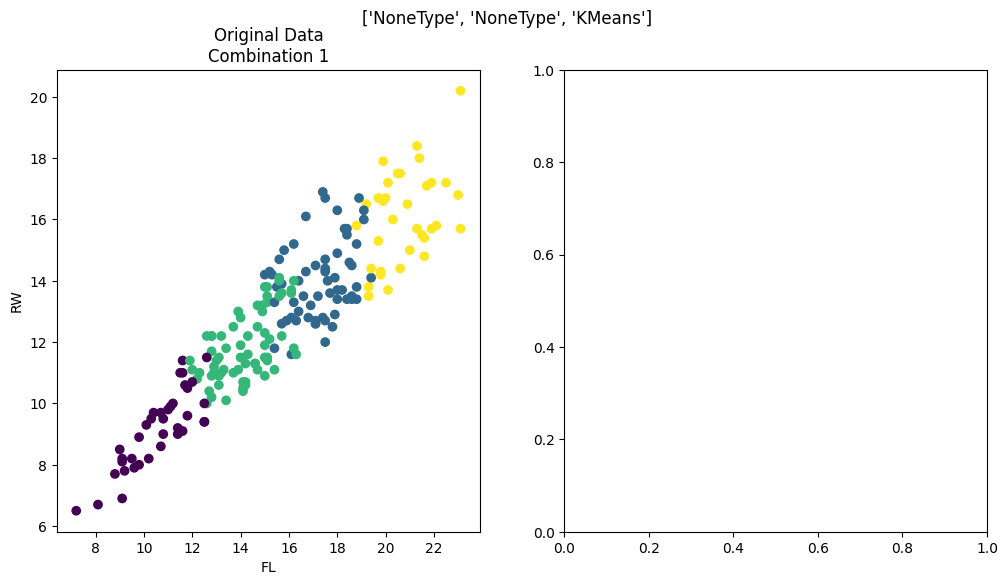

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': PCA(n_components=2), 'standardize': True}
adjusted_rand_score=0.02068482350527869 adjusted_mutual_info_score=0.035422744469444906


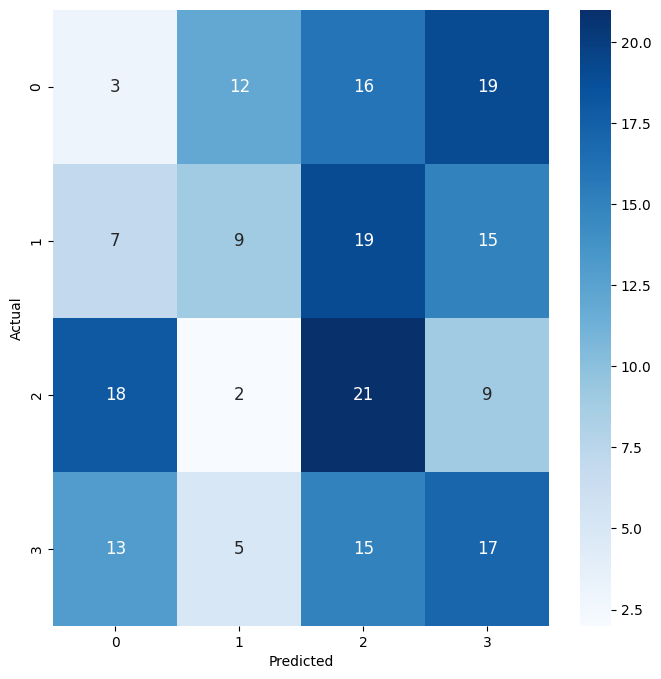

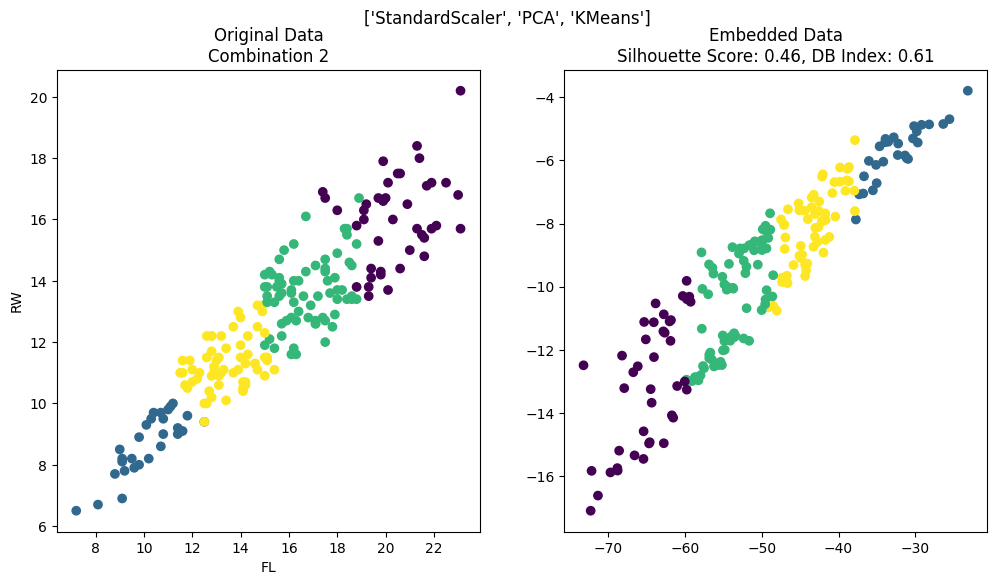

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': PCA(n_components=2), 'standardize': False}
adjusted_rand_score=0.01573616840753068 adjusted_mutual_info_score=0.03413401623539328


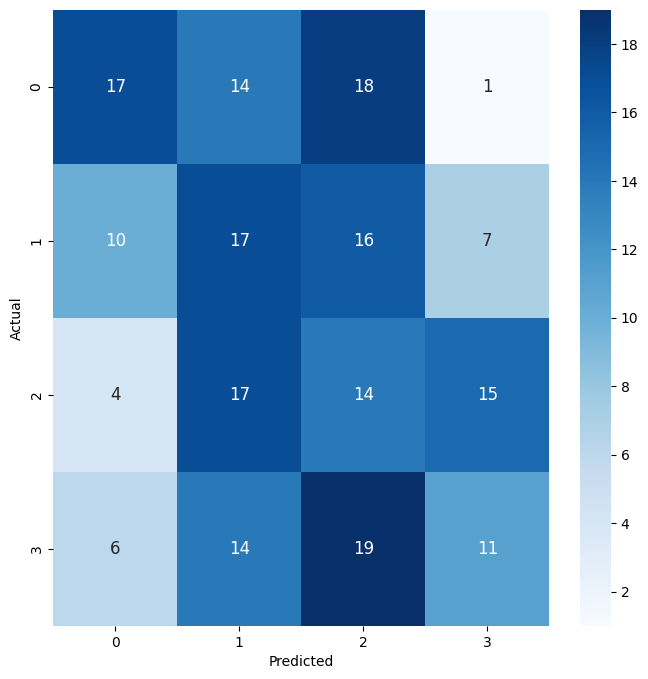

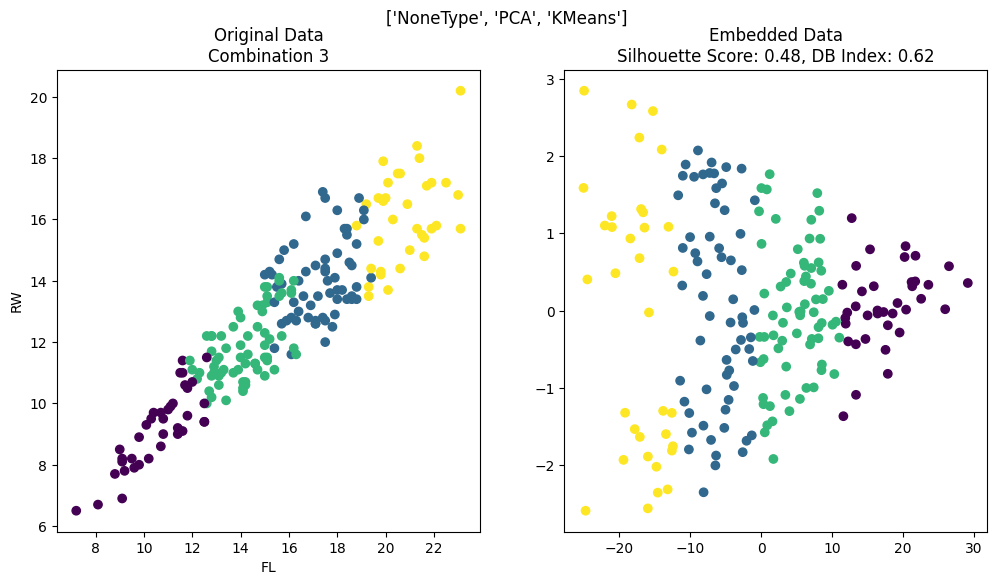

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': True}
adjusted_rand_score=0.02068482350527869 adjusted_mutual_info_score=0.03542274446944491


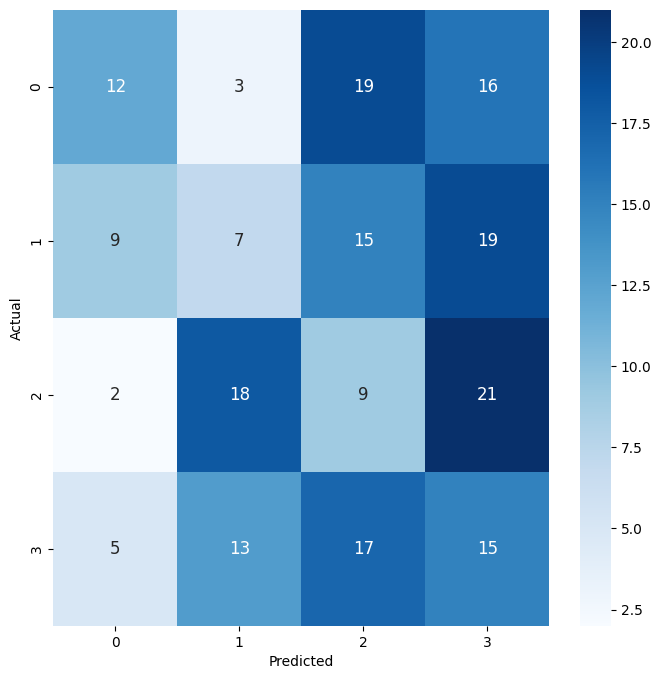

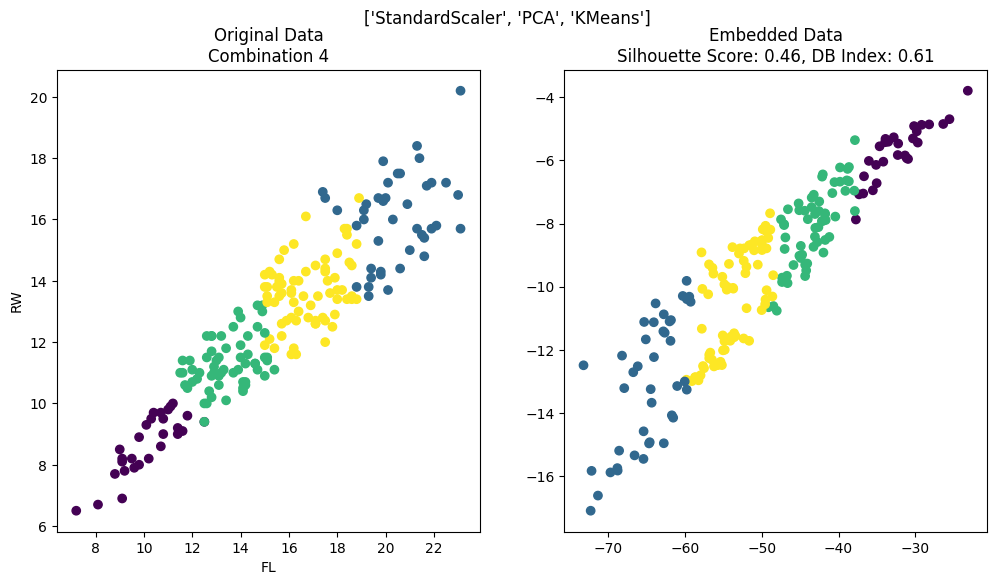

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': False}
adjusted_rand_score=0.01573616840753068 adjusted_mutual_info_score=0.03413401623539328


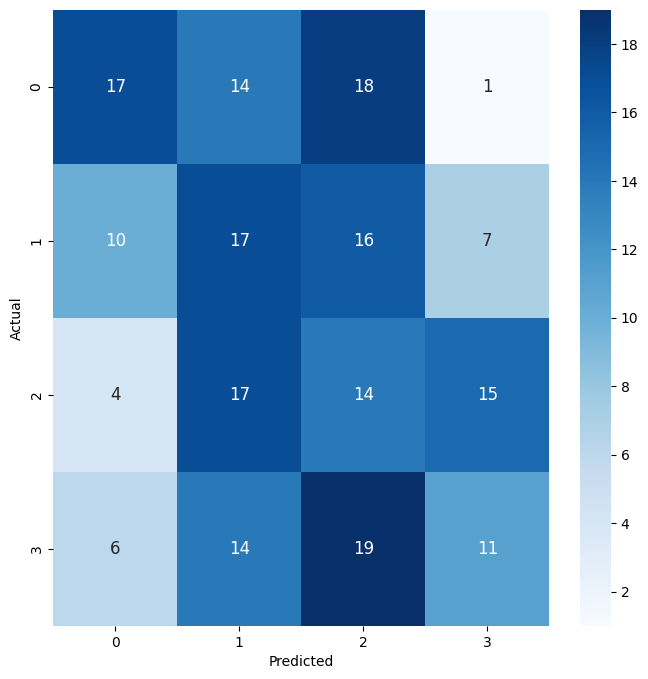

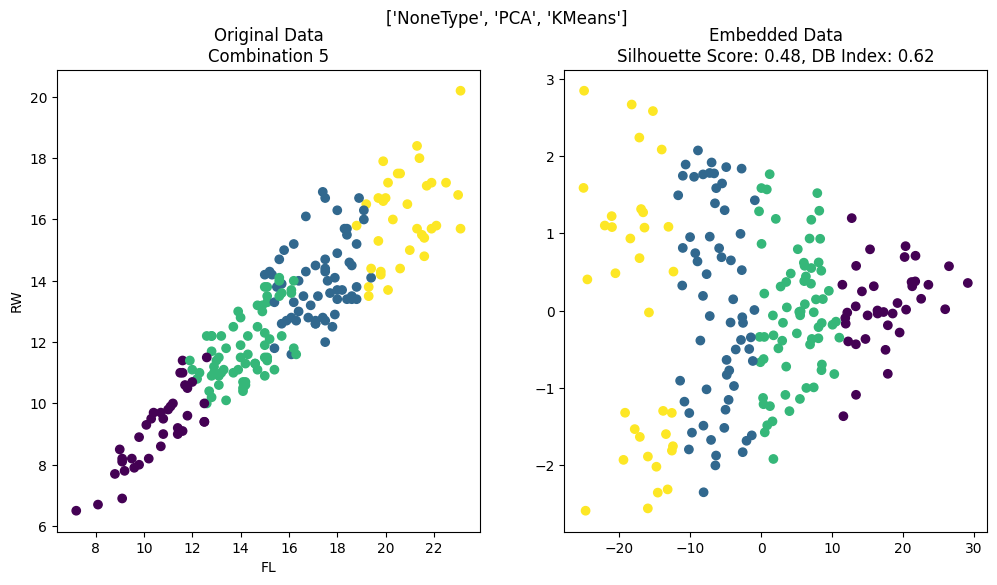

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': True}
adjusted_rand_score=0.04850732941554647 adjusted_mutual_info_score=0.08050511950005211


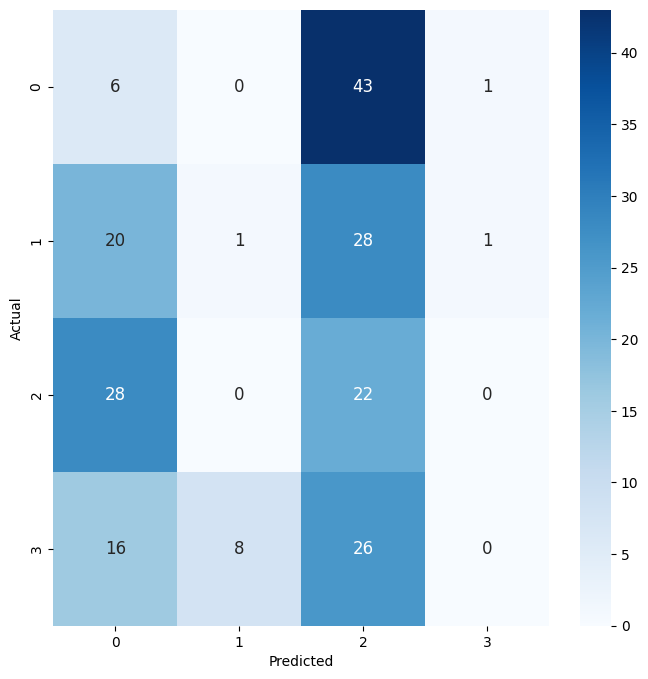

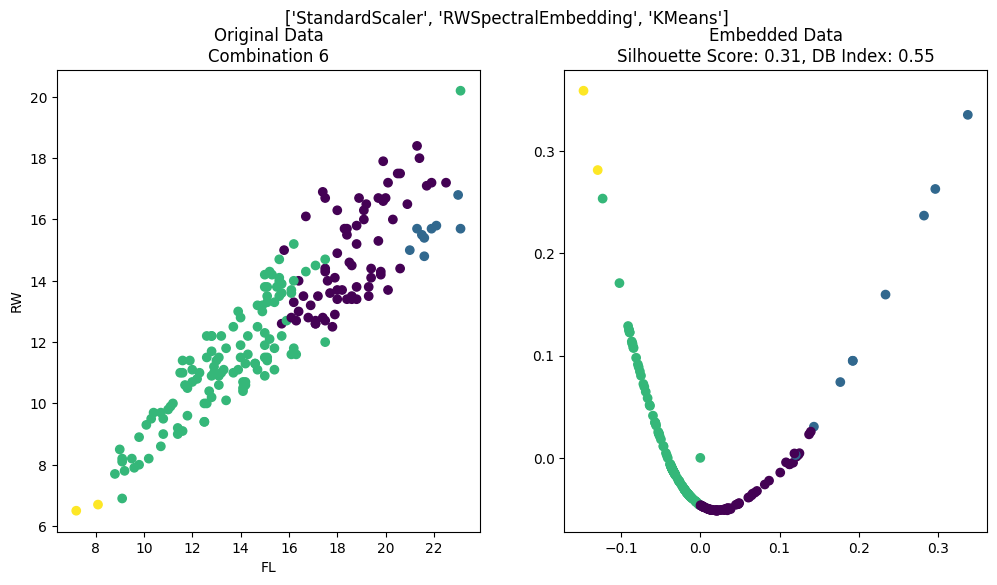

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': False}
adjusted_rand_score=0.04266923535152537 adjusted_mutual_info_score=0.051711982563752916


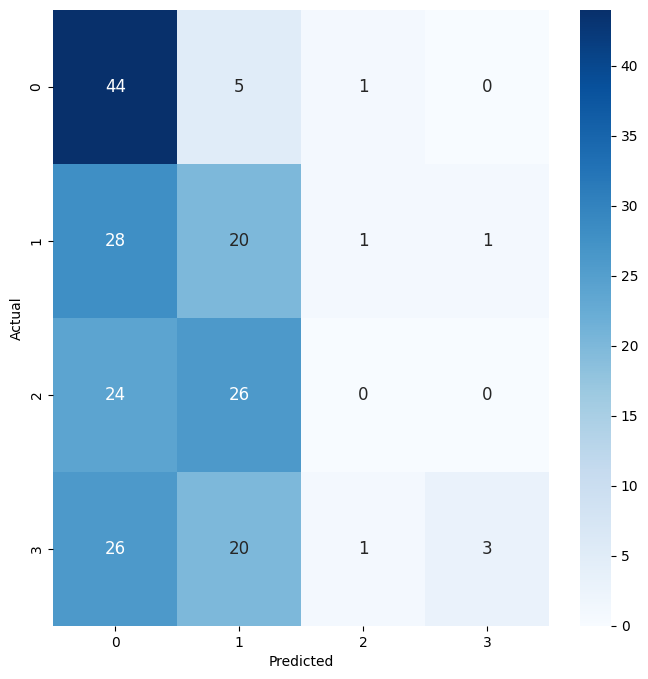

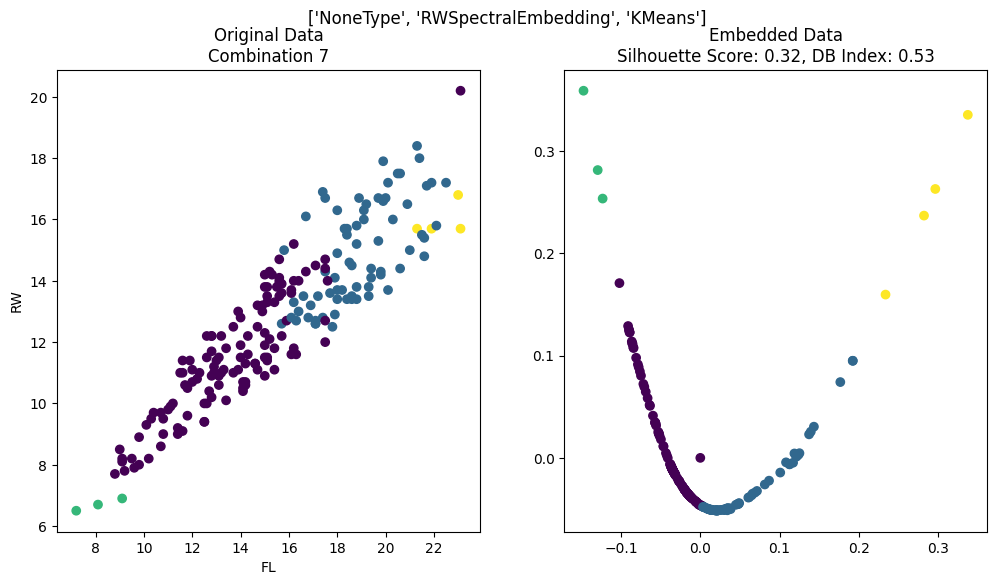

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': True}
adjusted_rand_score=0.0443883921849181 adjusted_mutual_info_score=0.05487287781720466


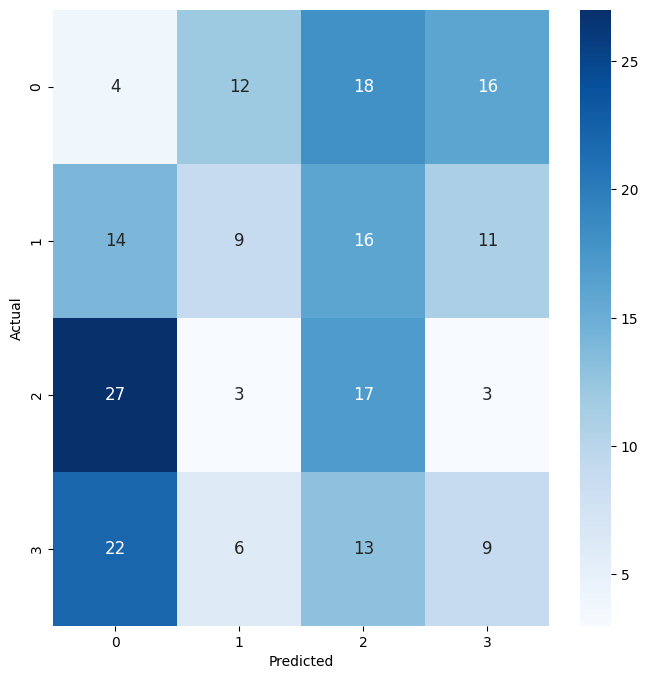

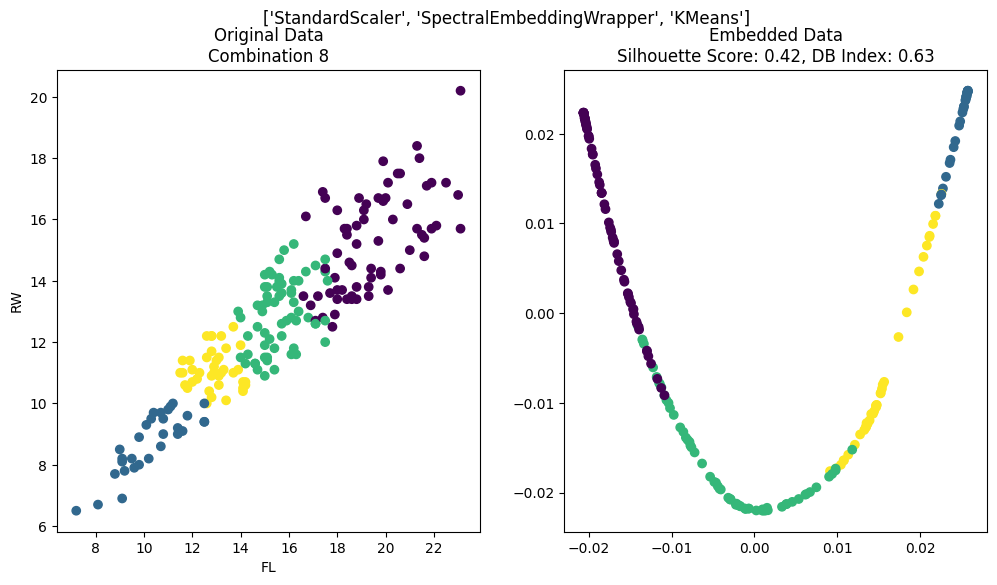

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': False}
adjusted_rand_score=0.020397082620138896 adjusted_mutual_info_score=0.029745590075637495


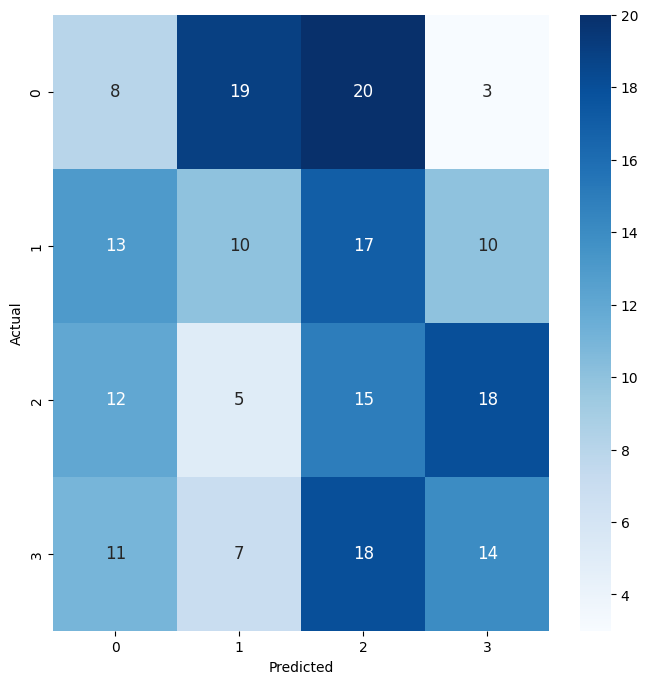

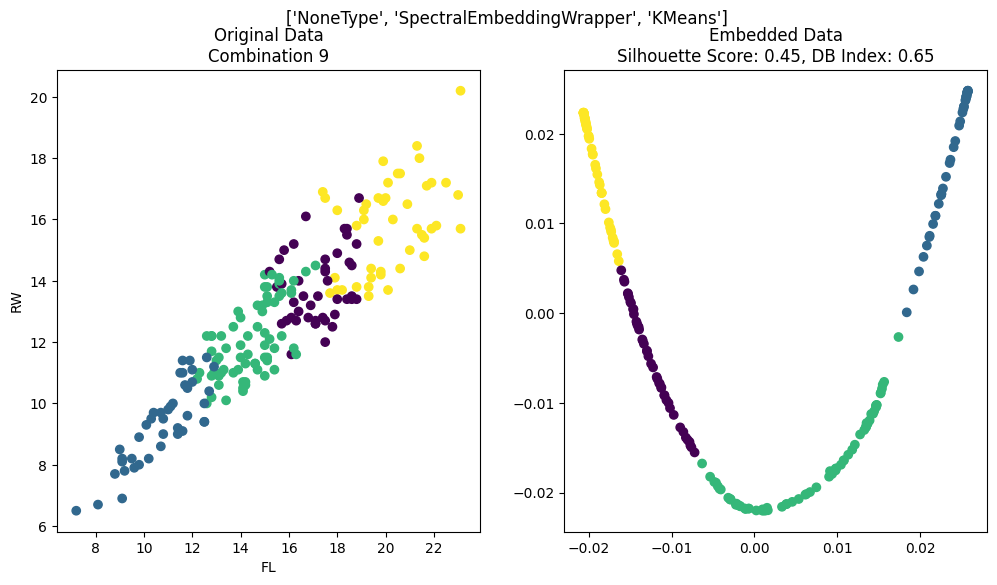

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': UMAP(), 'standardize': True}
adjusted_rand_score=0.0827732647996192 adjusted_mutual_info_score=0.13913245274972716


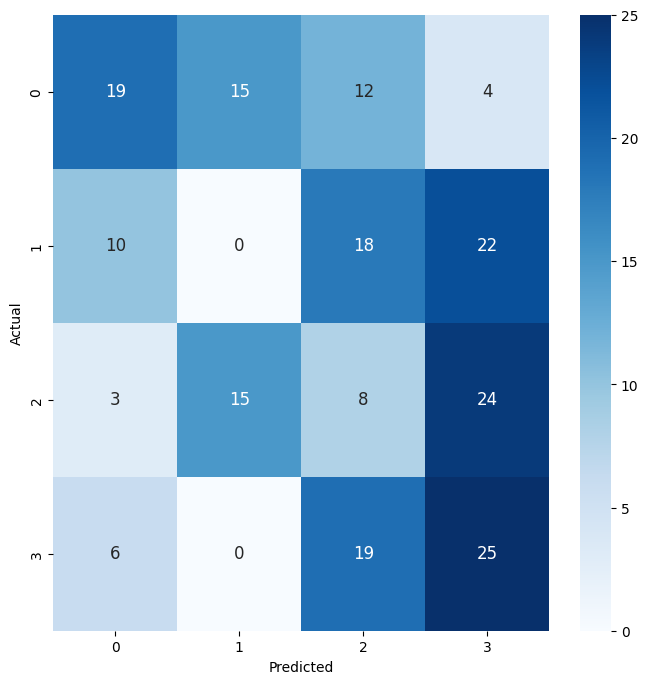

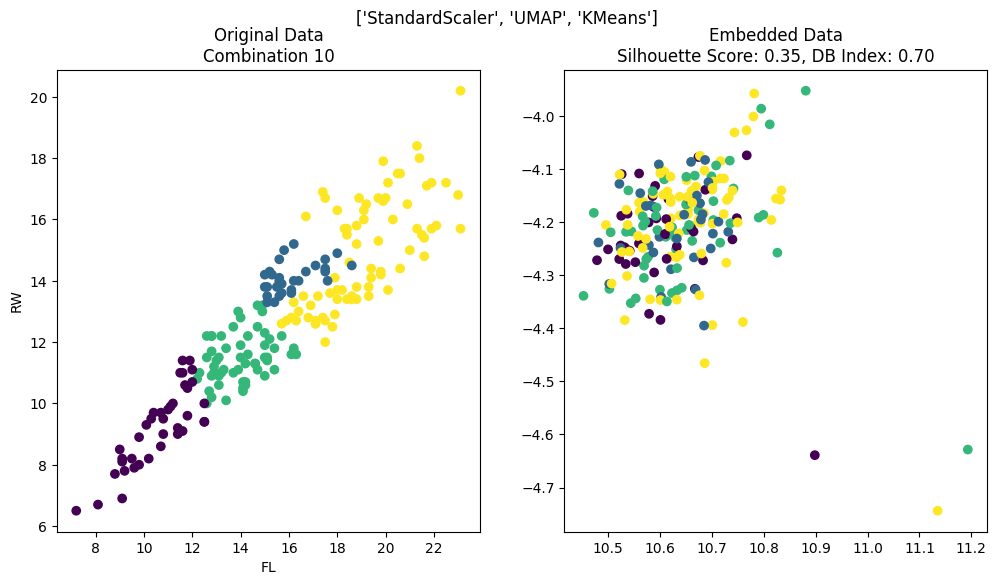

{'cluster': KMeans(n_clusters=4, random_state=42), 'reduce_dim': UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), 'standardize': False}
adjusted_rand_score=0.055848906931403056 adjusted_mutual_info_score=0.06277877555541445


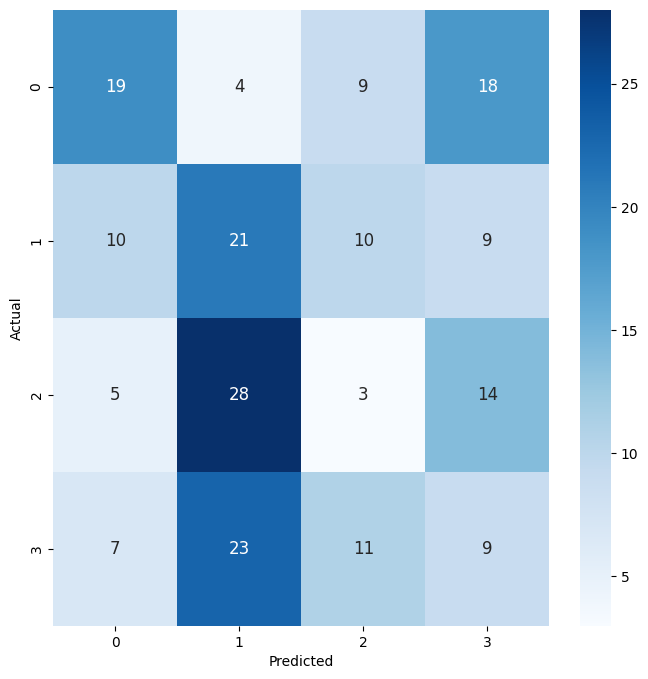

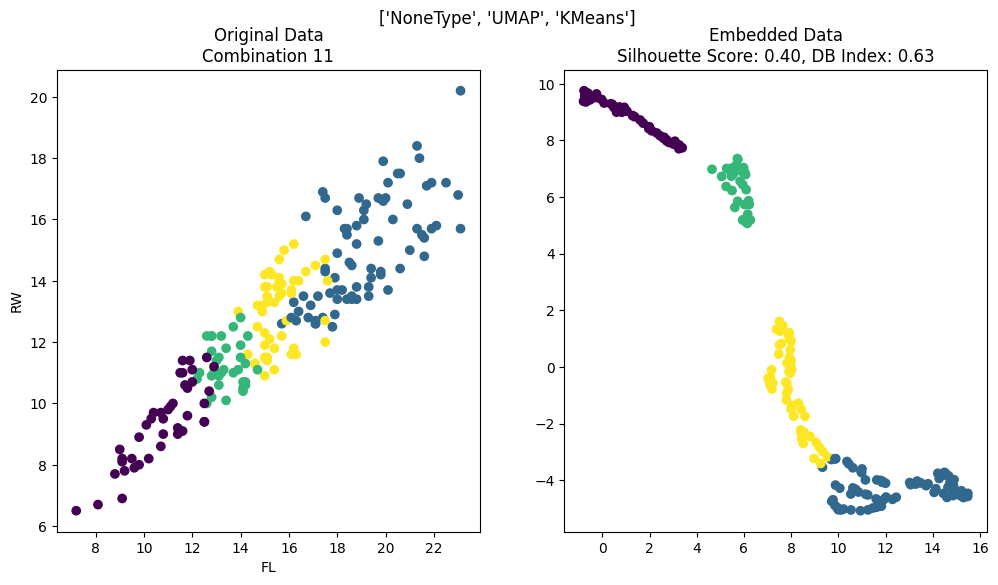

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': None, 'standardize': True}
adjusted_rand_score=0.07843317698926984 adjusted_mutual_info_score=0.26707011691028115


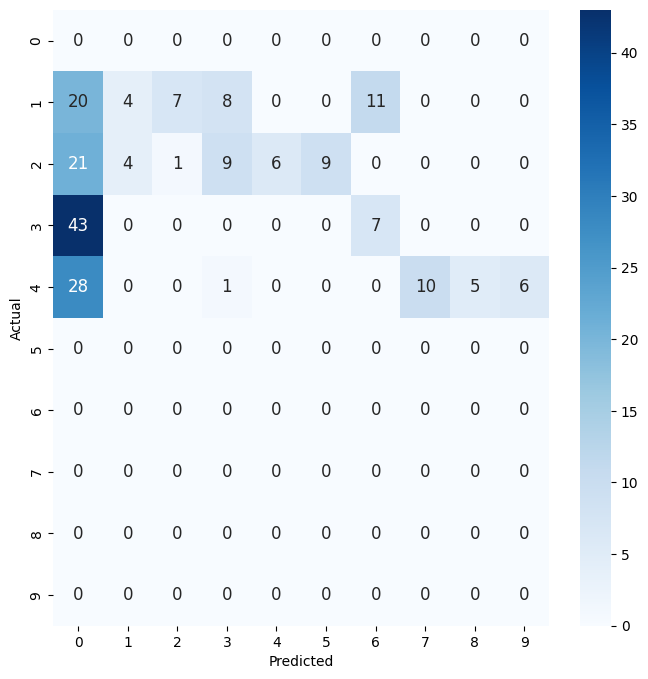

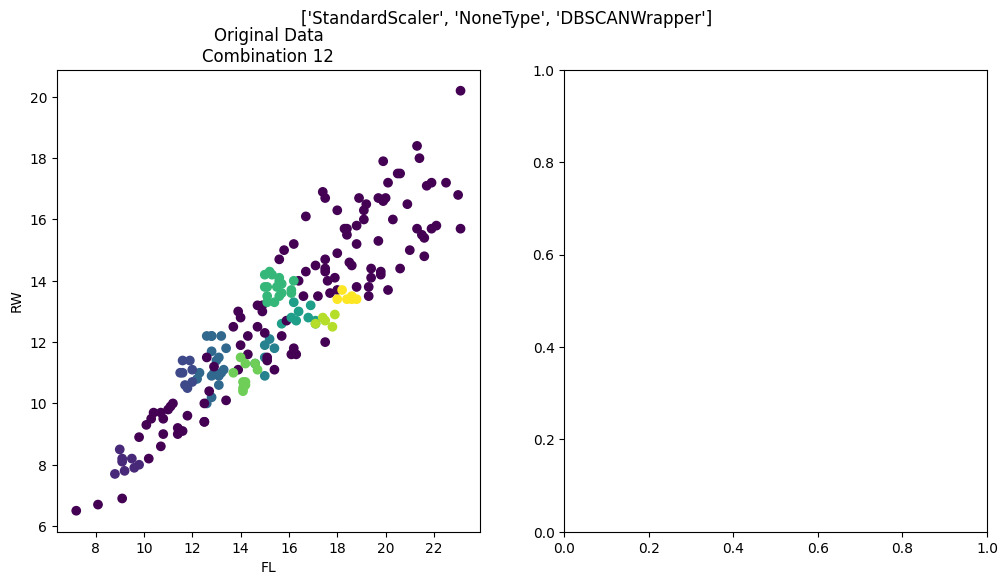

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': None, 'standardize': False}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


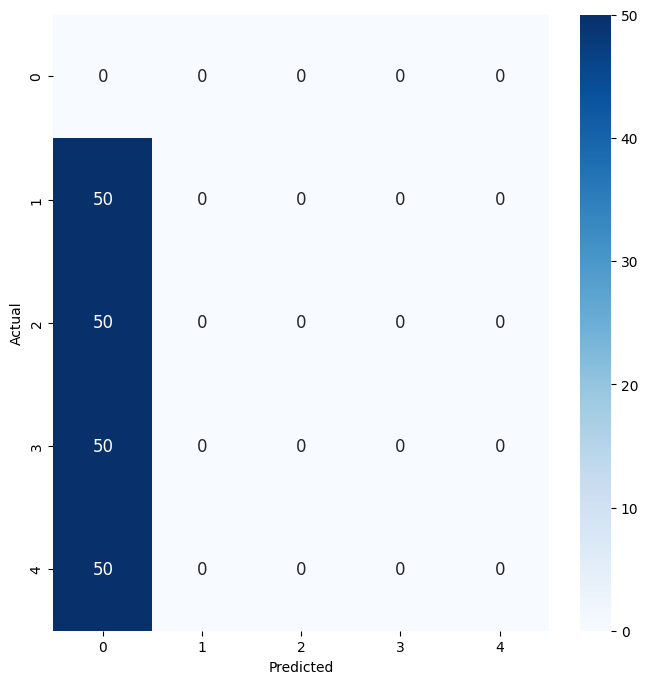

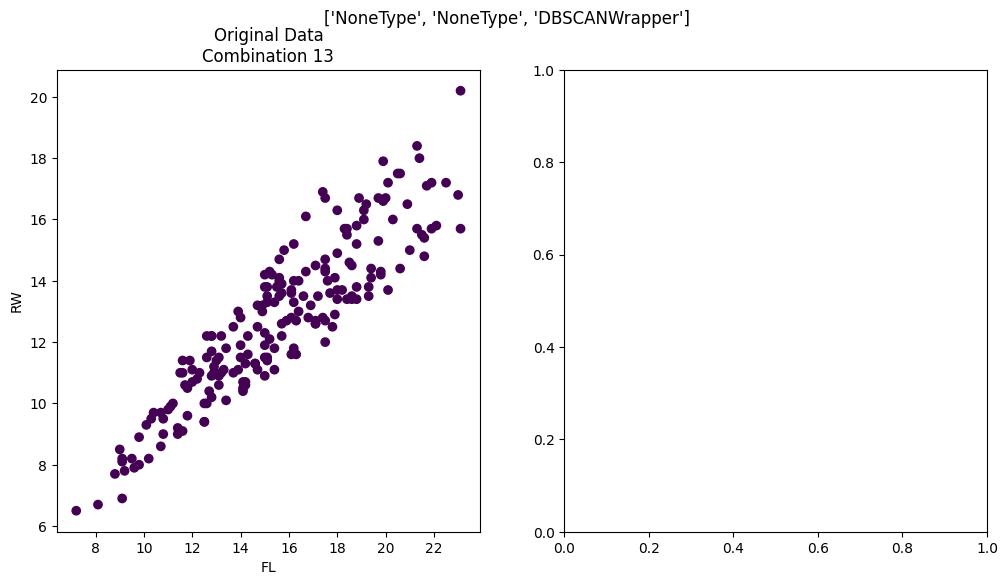

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': PCA(n_components=2), 'standardize': True}
adjusted_rand_score=0.09032189010276757 adjusted_mutual_info_score=0.20976324536744134


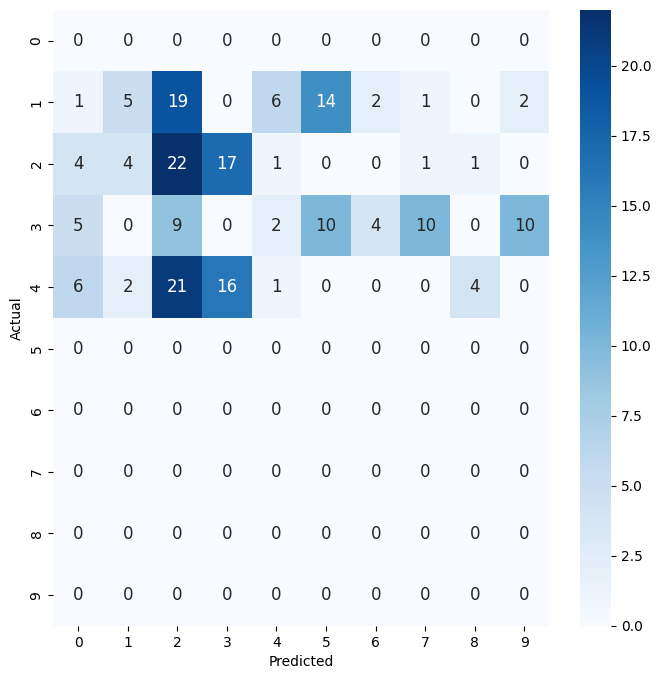

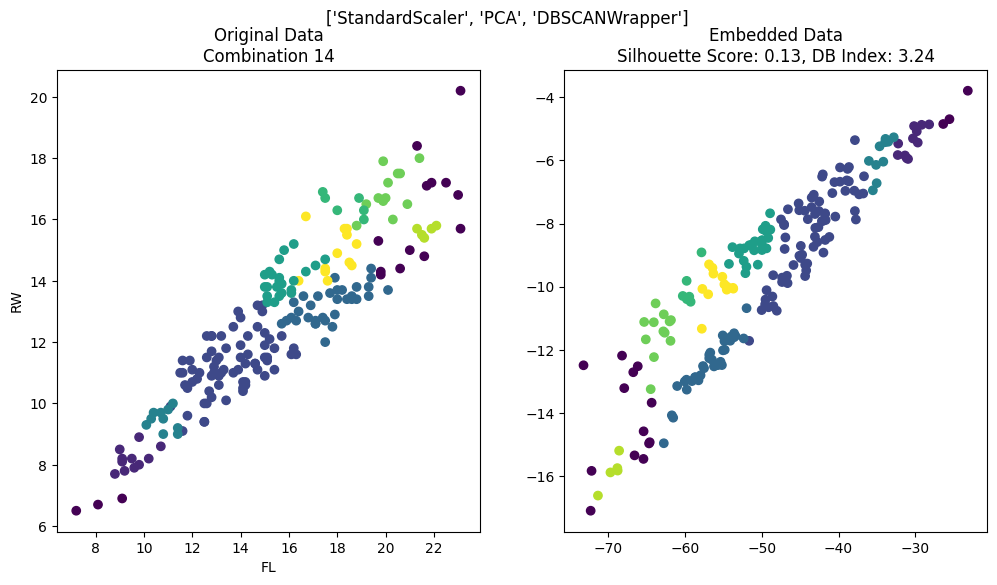

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': PCA(n_components=2), 'standardize': False}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


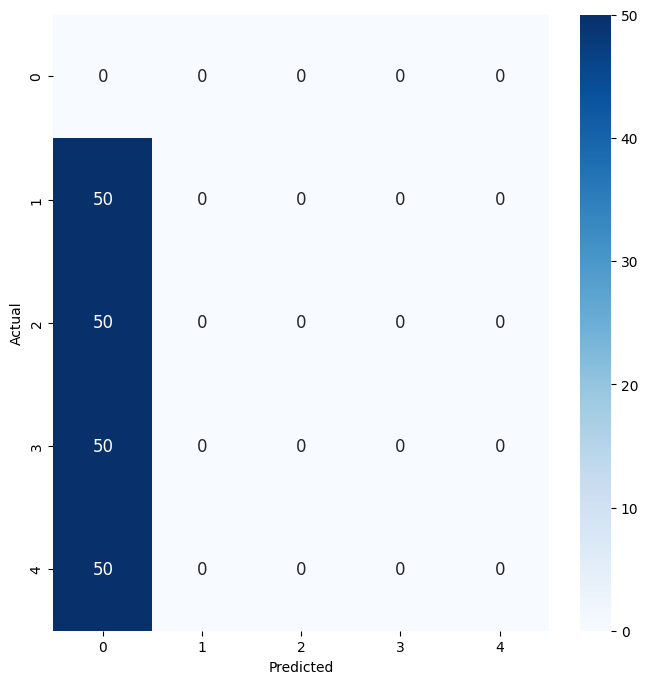

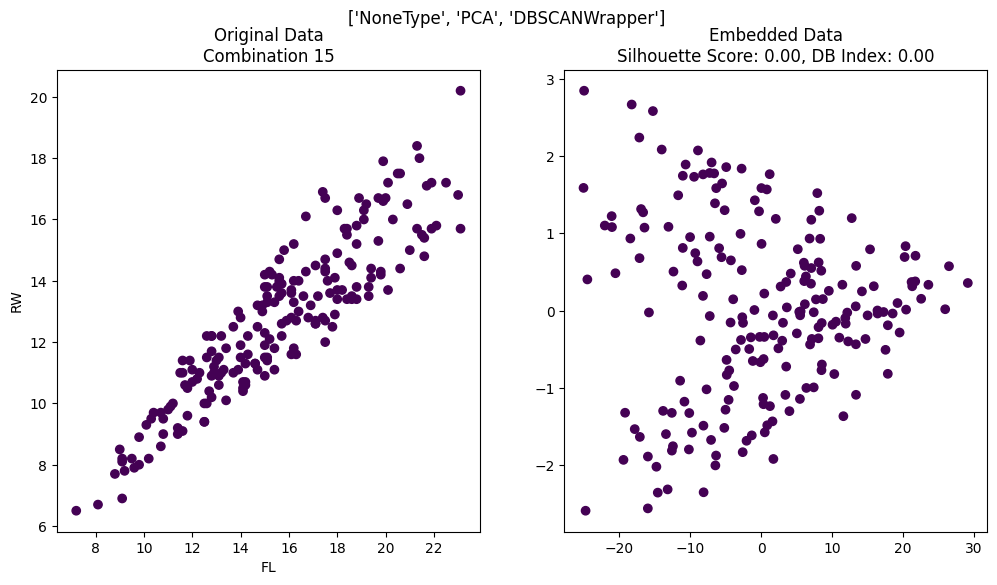

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': True}
adjusted_rand_score=0.08917876582904295 adjusted_mutual_info_score=0.289566470662788


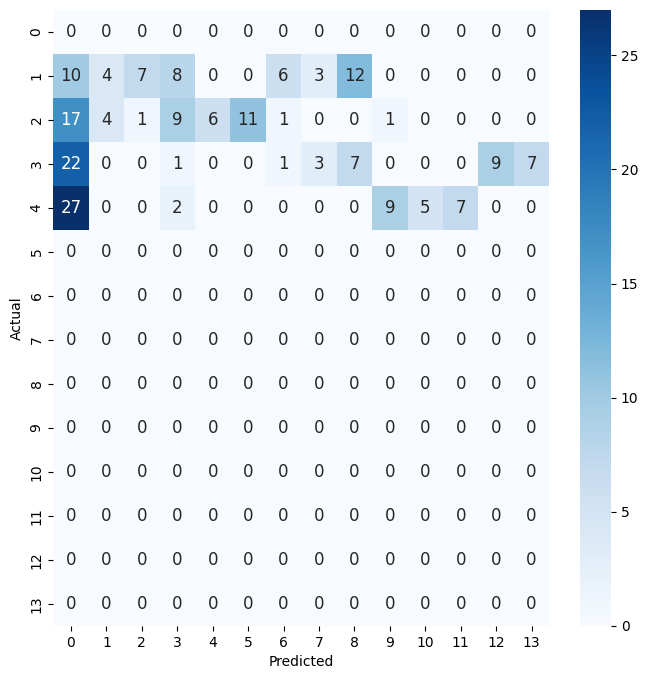

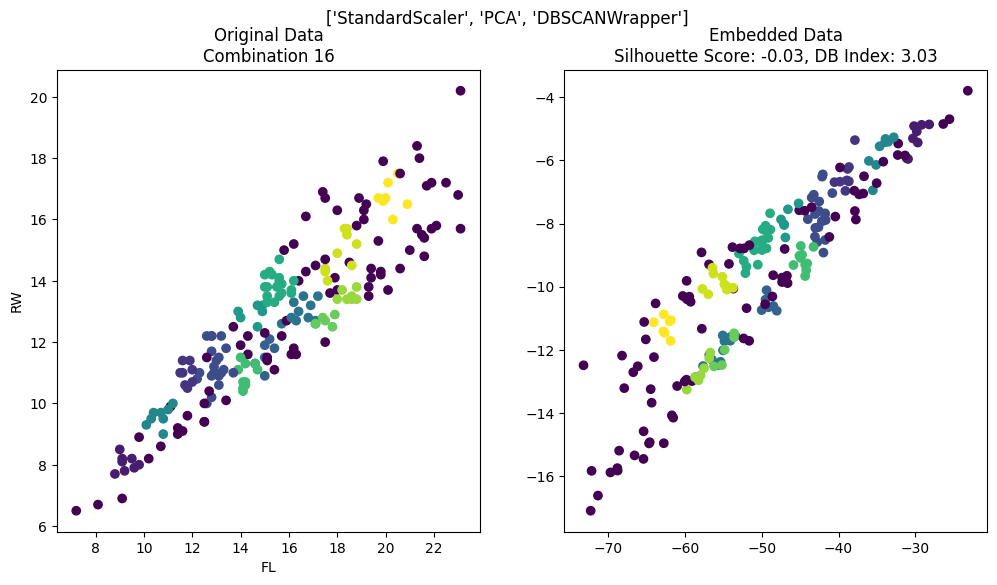

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': False}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


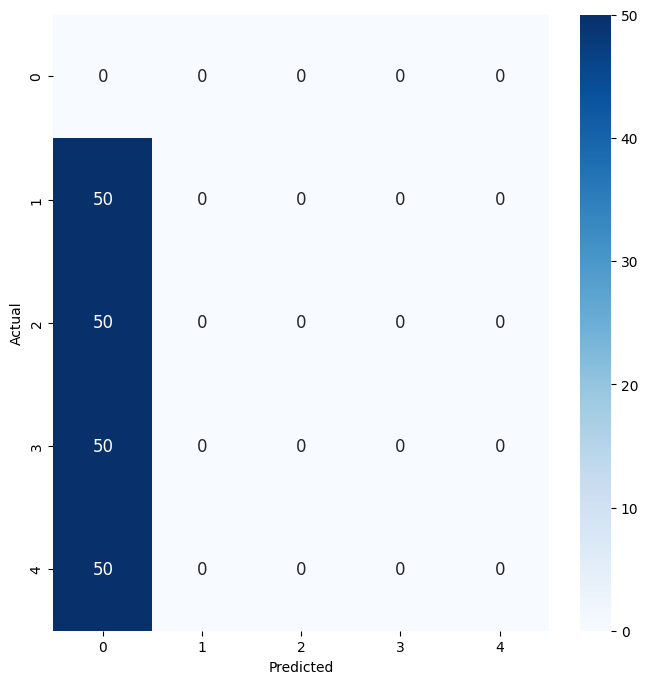

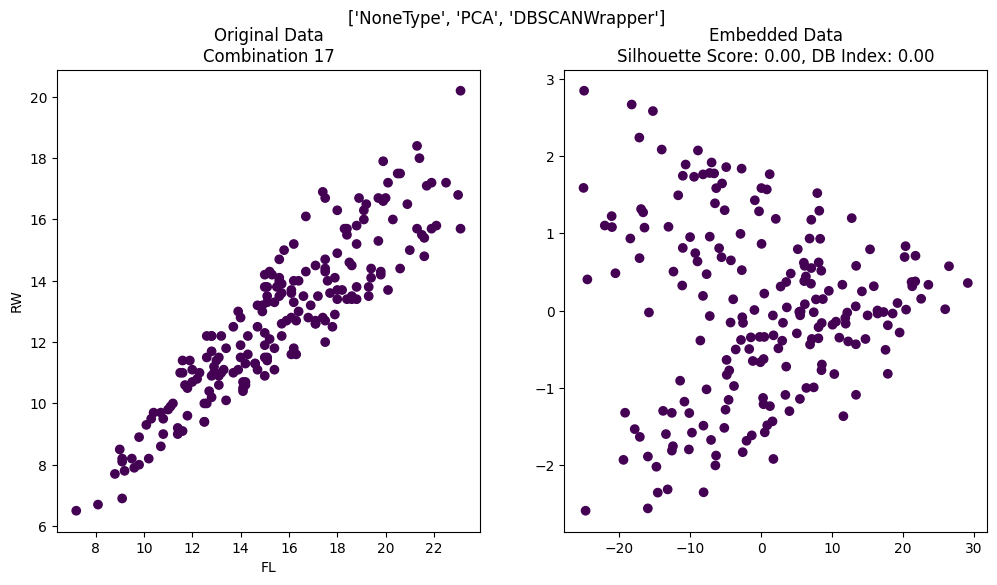

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': True}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


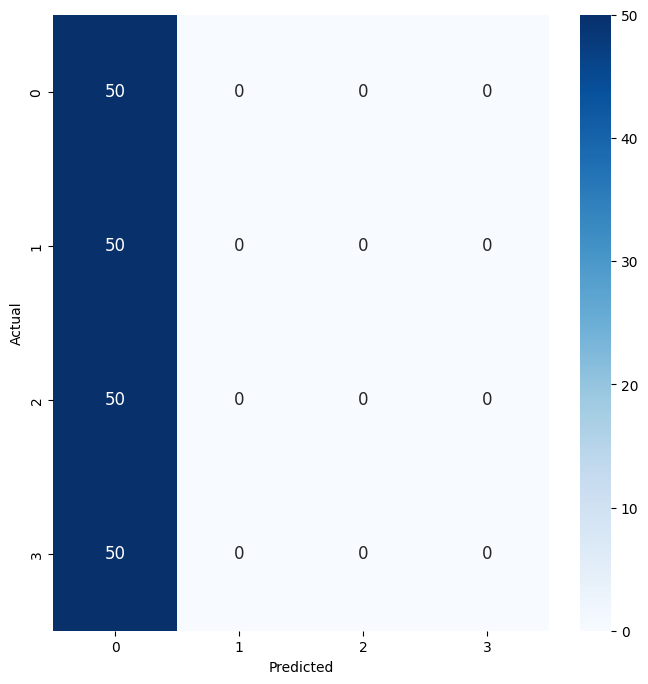

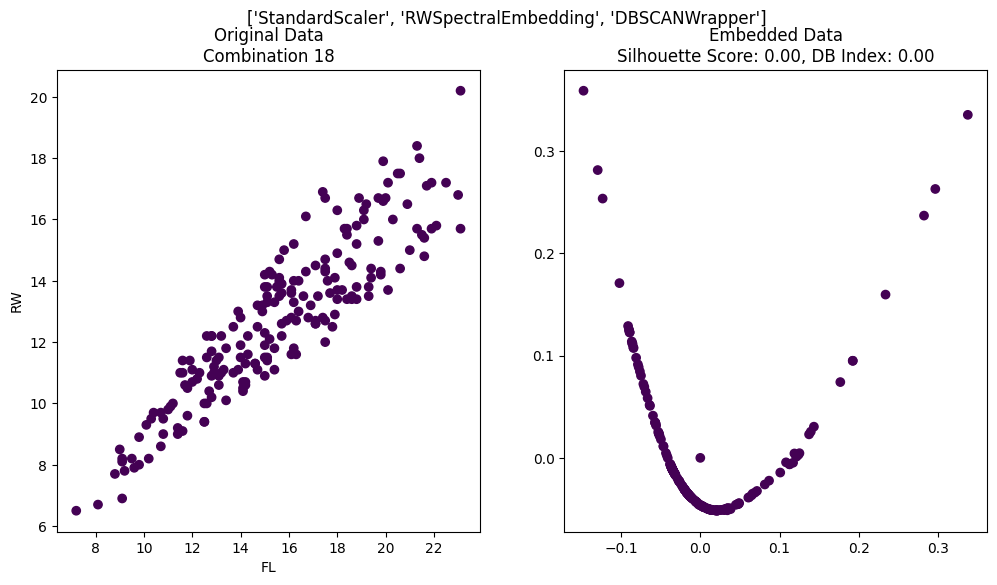

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': False}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


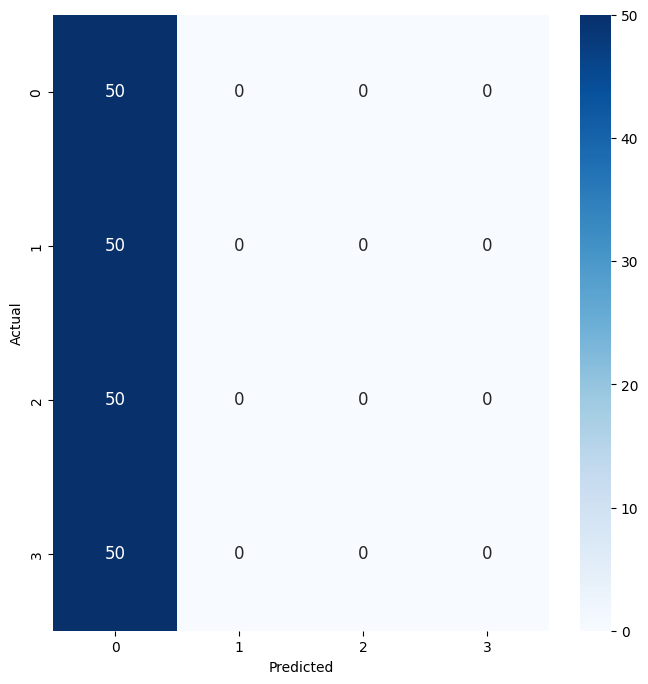

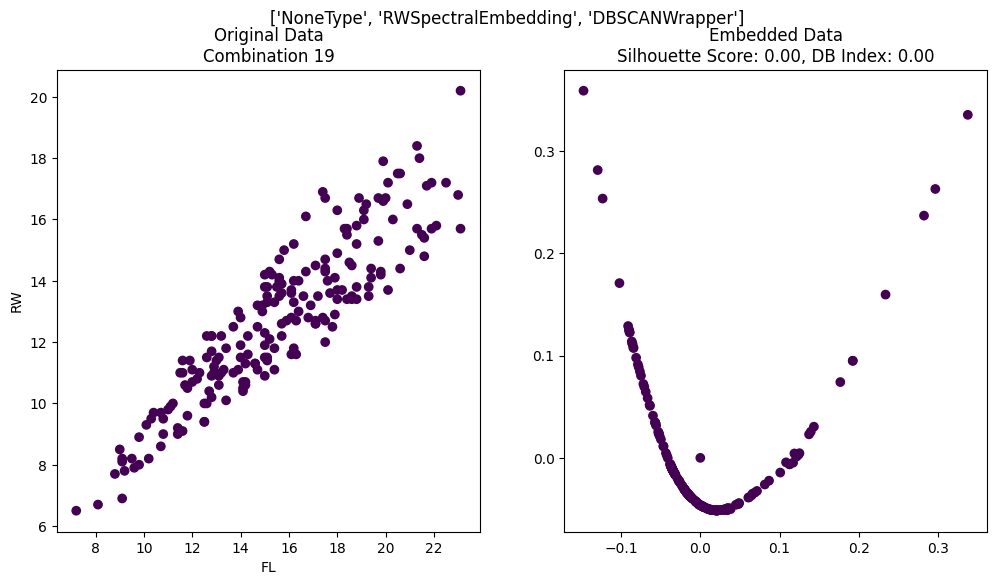

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': True}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


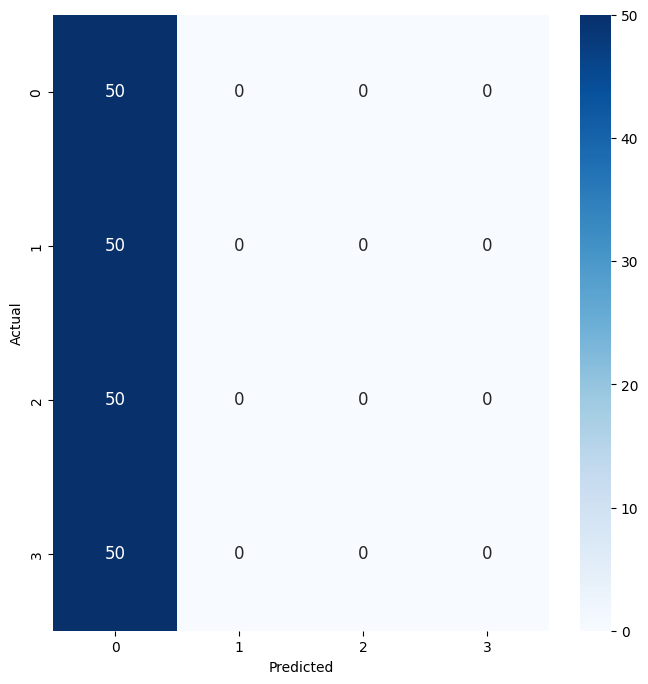

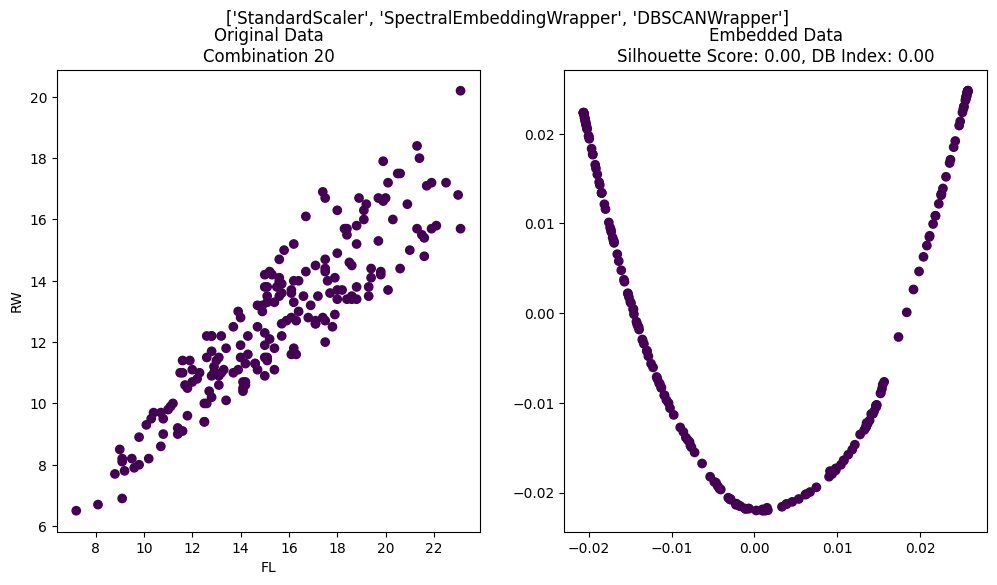

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': False}
adjusted_rand_score=0.0 adjusted_mutual_info_score=0.0


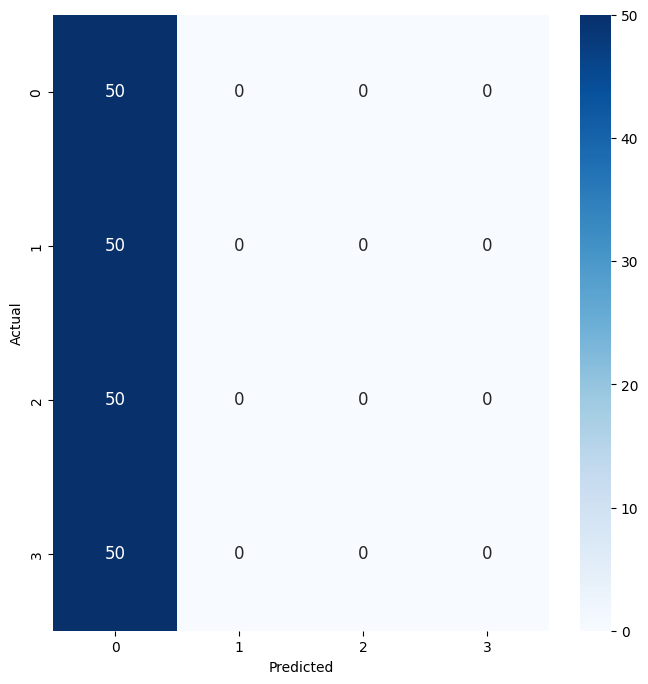

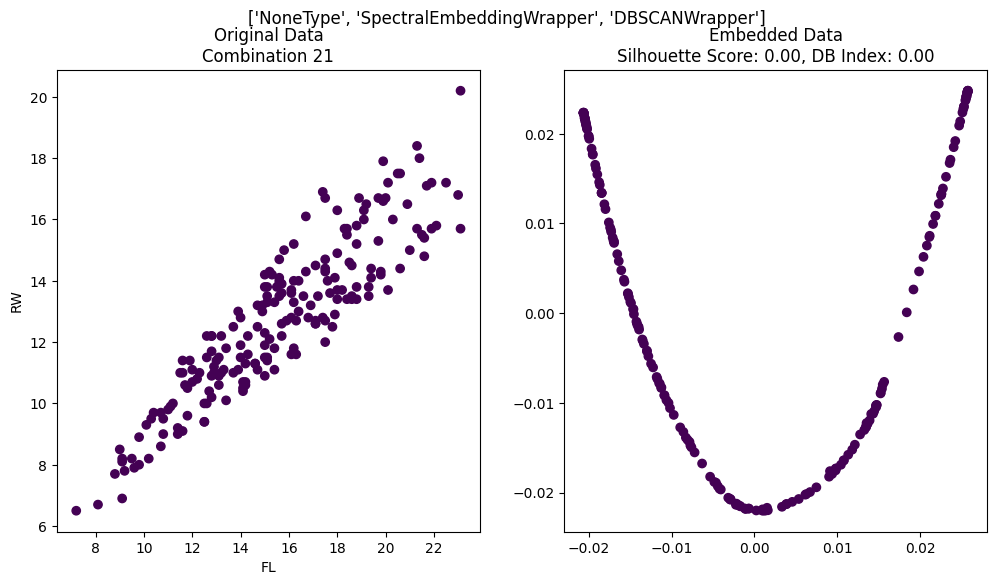

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), 'standardize': True}
adjusted_rand_score=0.09588650990803903 adjusted_mutual_info_score=0.28610075434784343


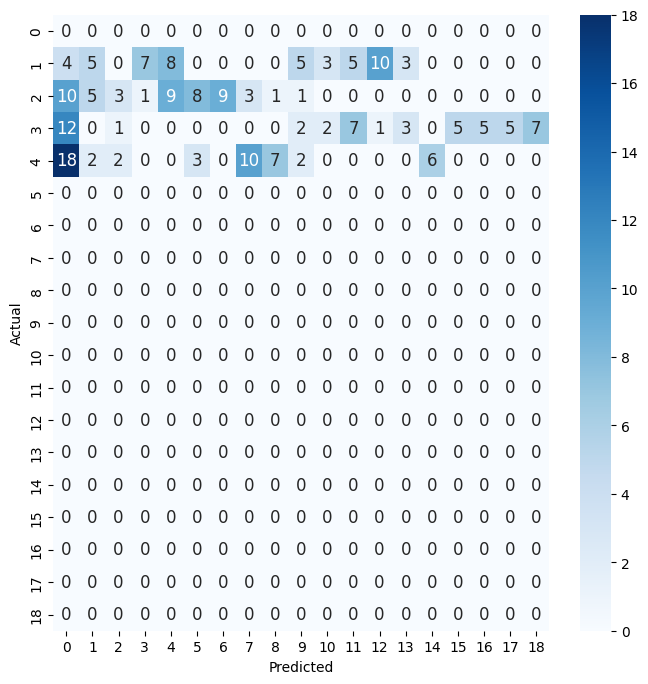

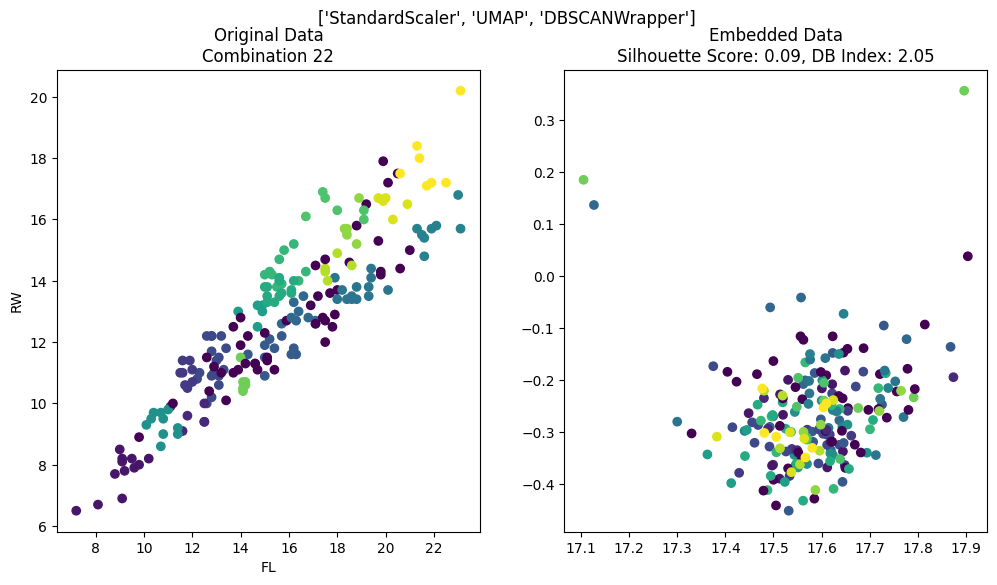

{'cluster': DBSCANWrapper(eps=0.3), 'reduce_dim': UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), 'standardize': False}
adjusted_rand_score=0.05919859729044847 adjusted_mutual_info_score=0.20116666933925673


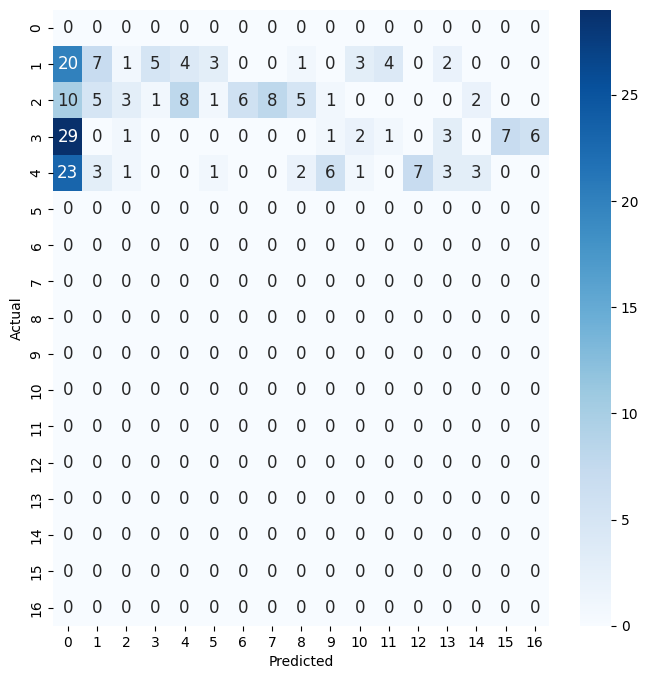

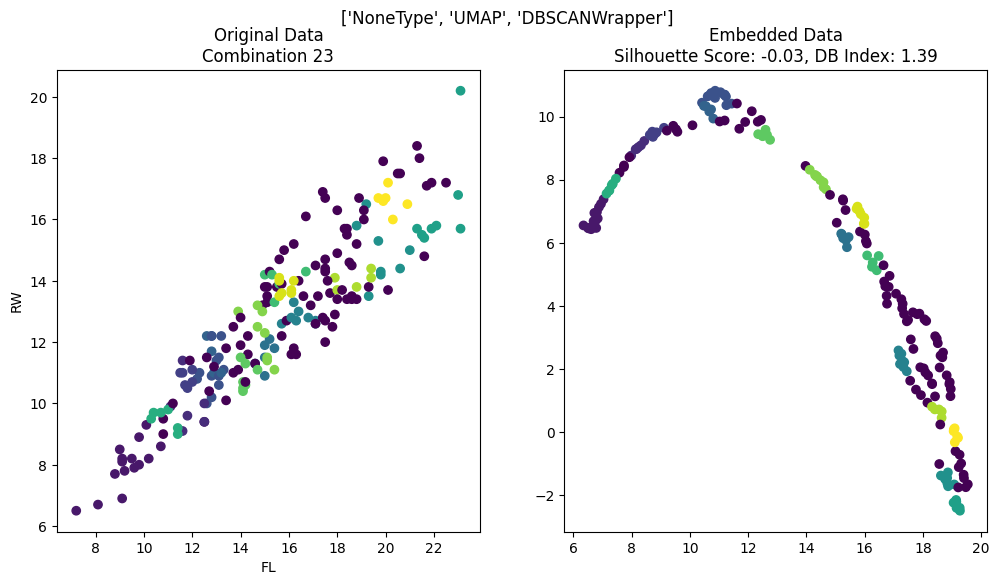

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': None, 'standardize': True}
adjusted_rand_score=0.02066788342393666 adjusted_mutual_info_score=0.031172897515794332


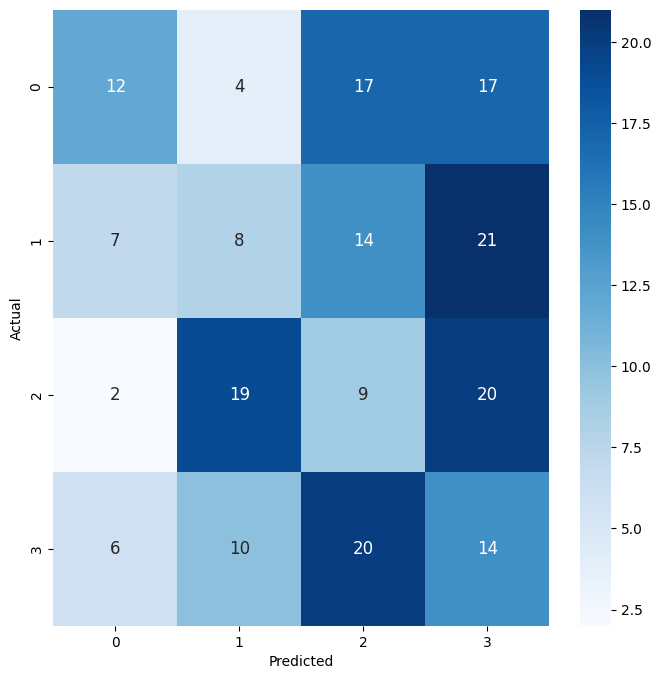

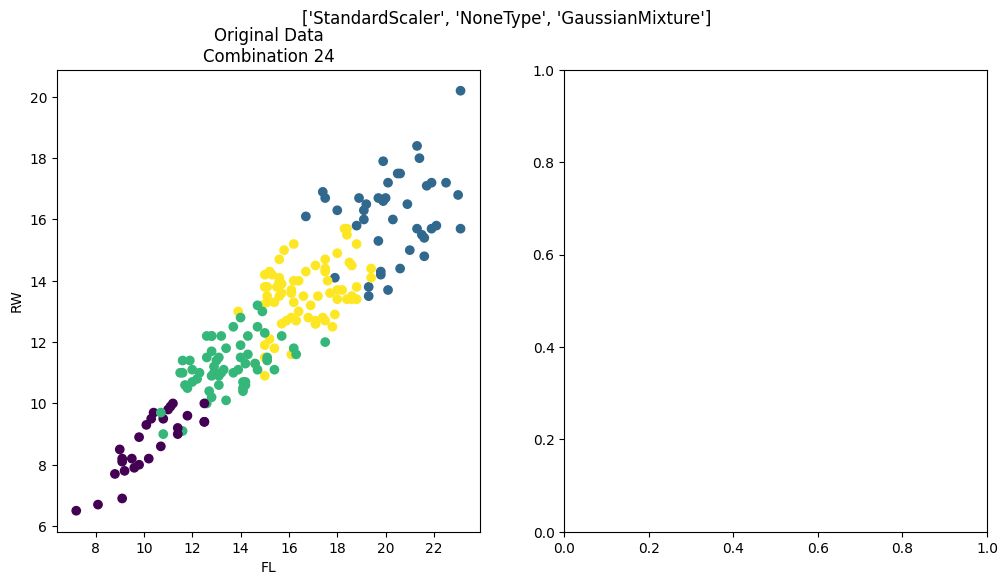

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': None, 'standardize': False}
adjusted_rand_score=0.031724891102947815 adjusted_mutual_info_score=0.05164870300660342


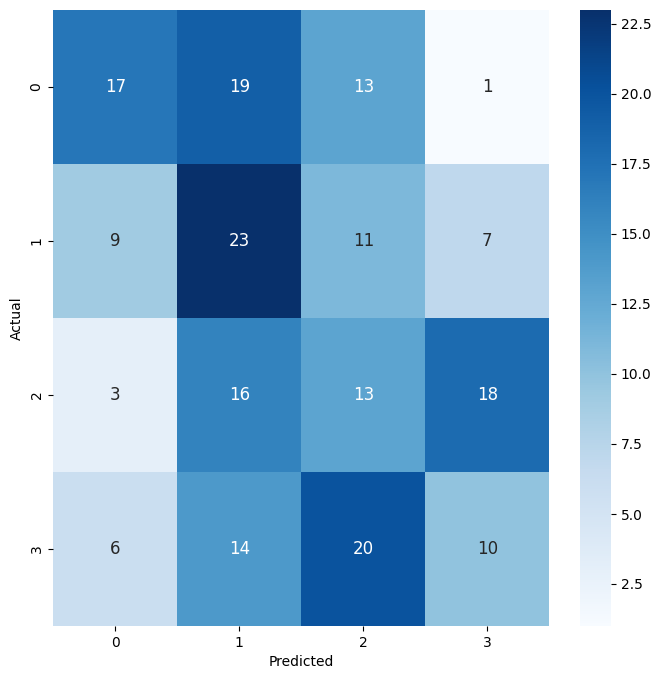

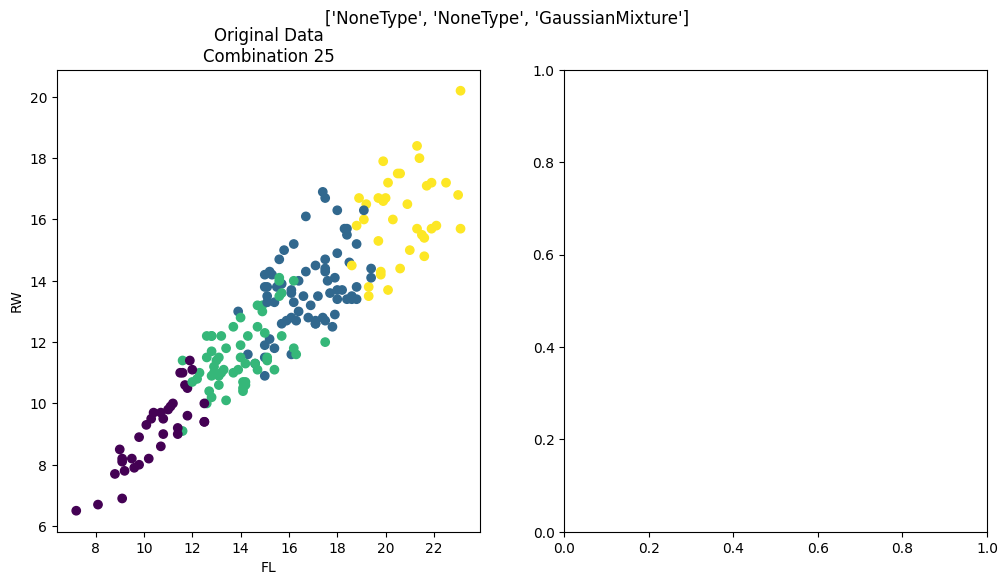

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': PCA(n_components=2), 'standardize': True}
adjusted_rand_score=0.04120325218344882 adjusted_mutual_info_score=0.05511709793021101


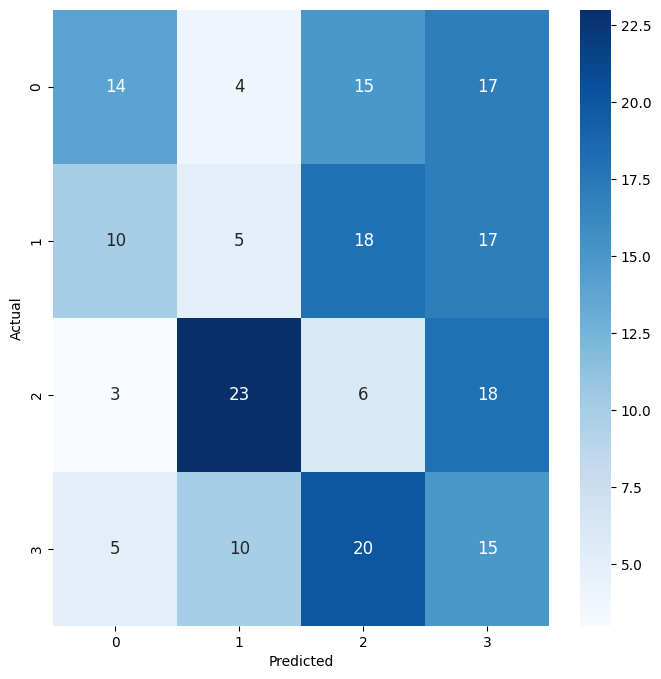

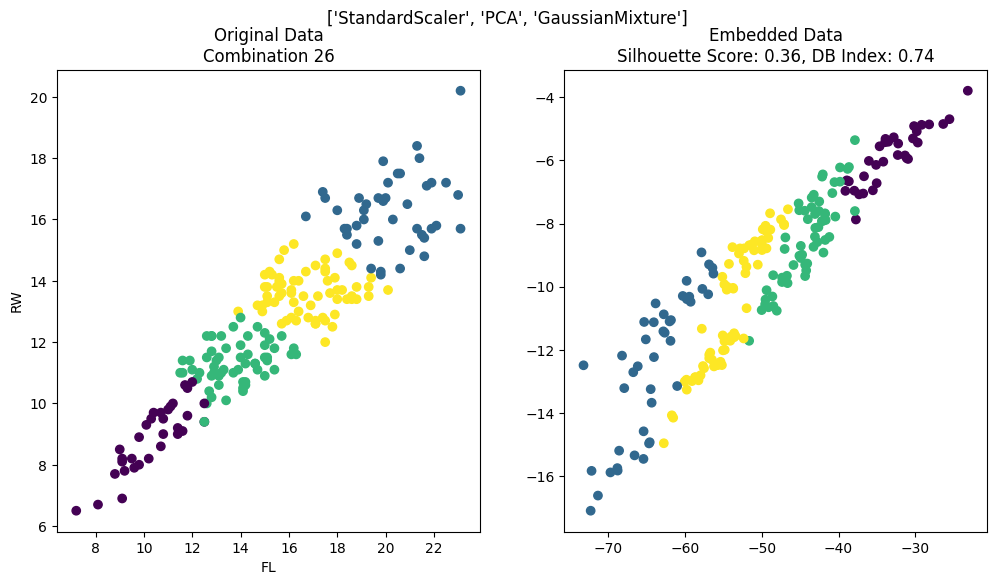

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': PCA(n_components=2), 'standardize': False}
adjusted_rand_score=0.02490614593492214 adjusted_mutual_info_score=0.044759822022311845


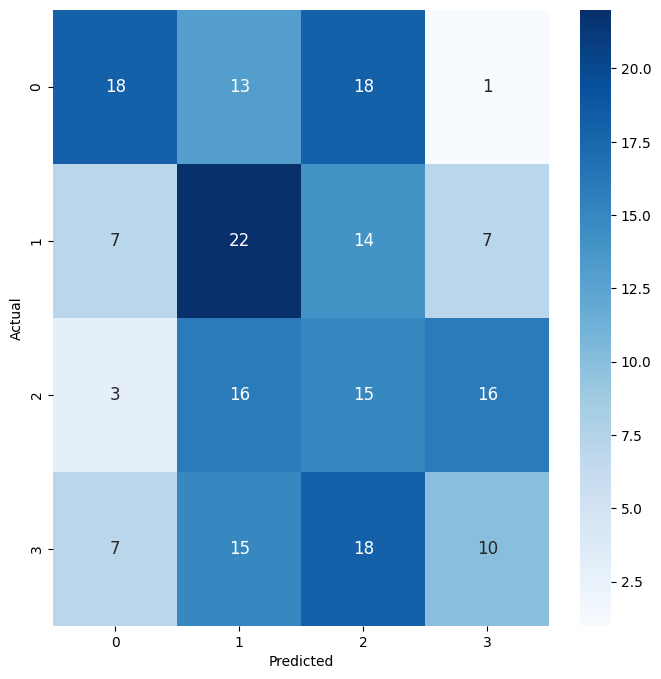

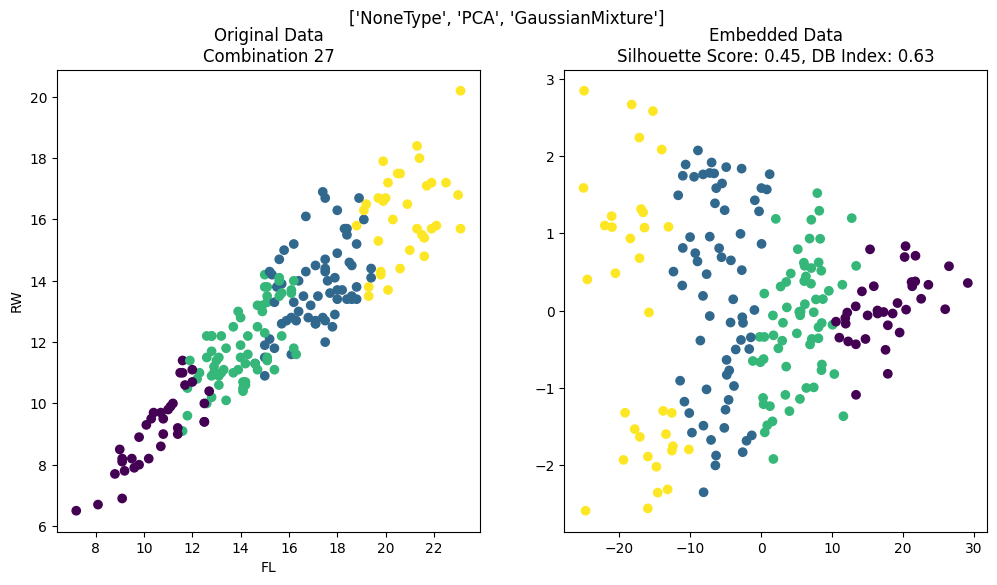

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': True}
adjusted_rand_score=0.026521229074011745 adjusted_mutual_info_score=0.036978018362285925


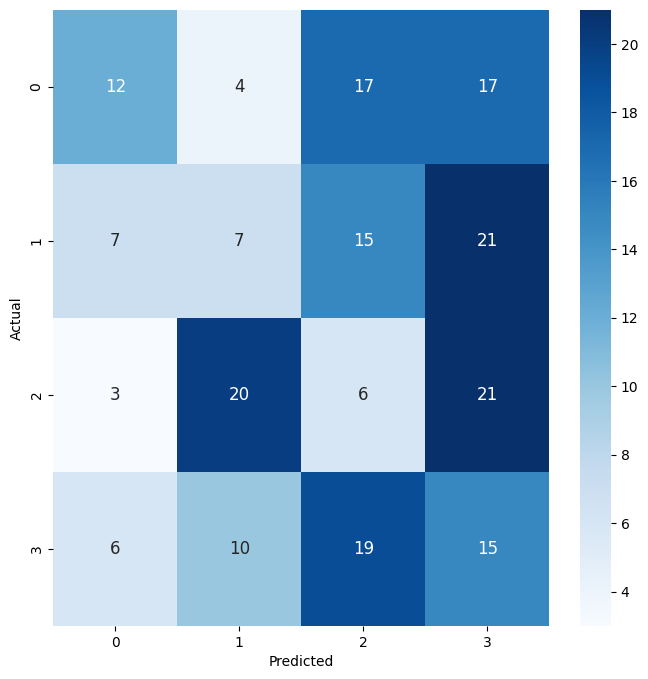

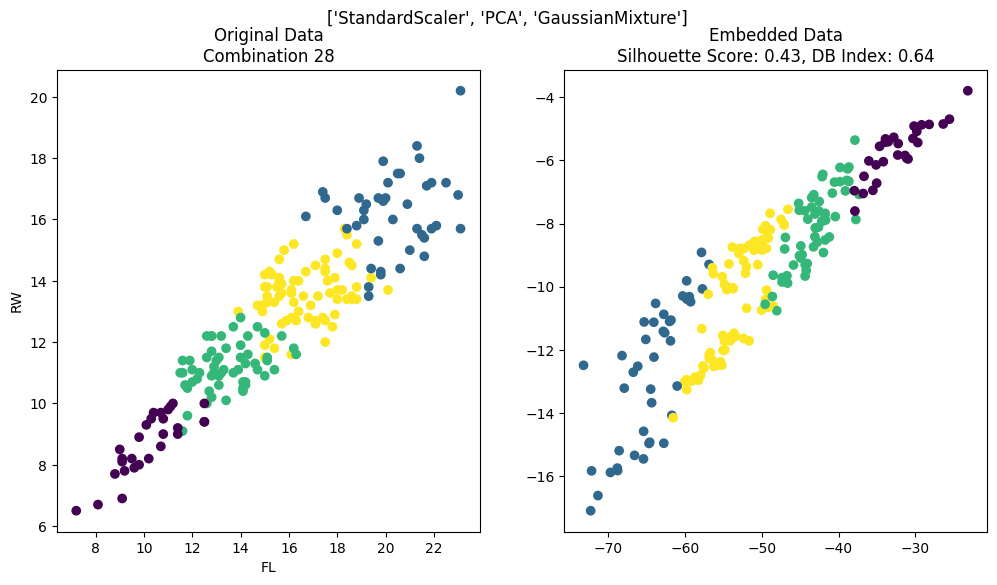

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': PCA(n_components=3, svd_solver='full'), 'standardize': False}
adjusted_rand_score=0.029255485815871844 adjusted_mutual_info_score=0.042756636432212586


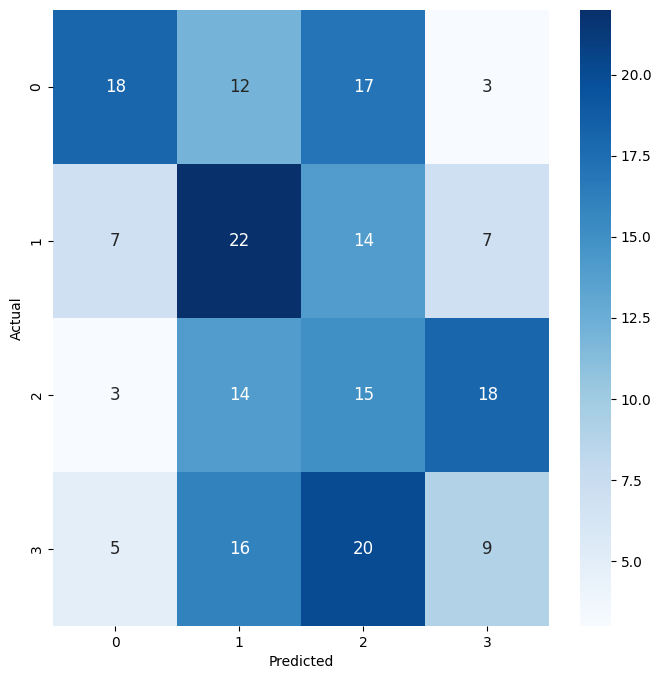

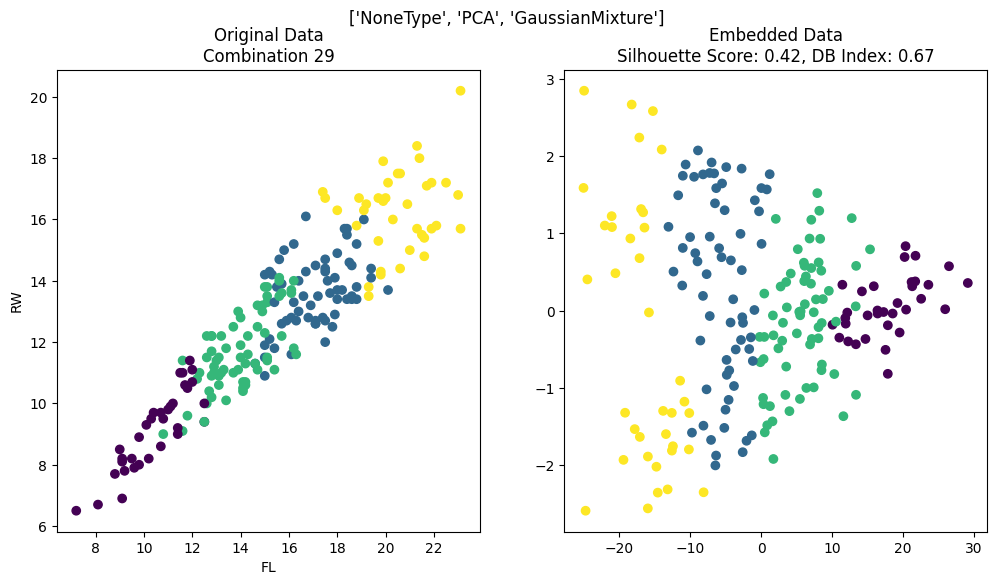

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': True}
adjusted_rand_score=0.04894858049703894 adjusted_mutual_info_score=0.09629263716748483


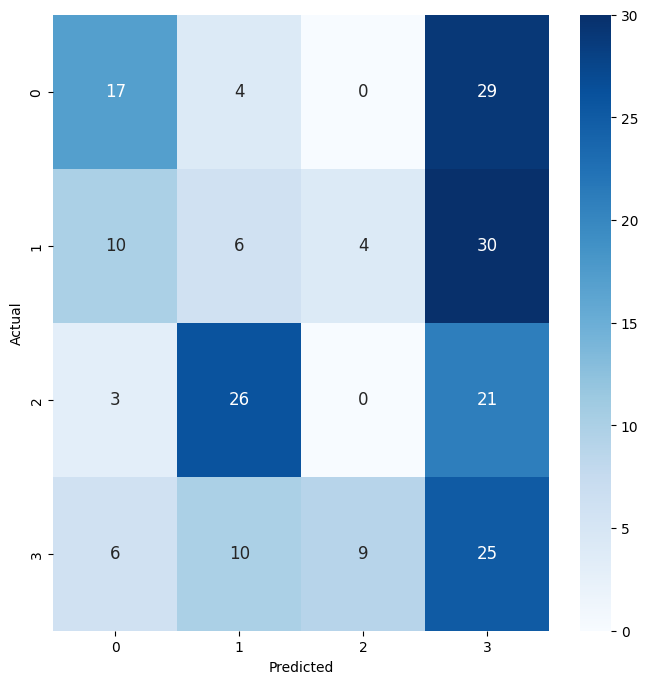

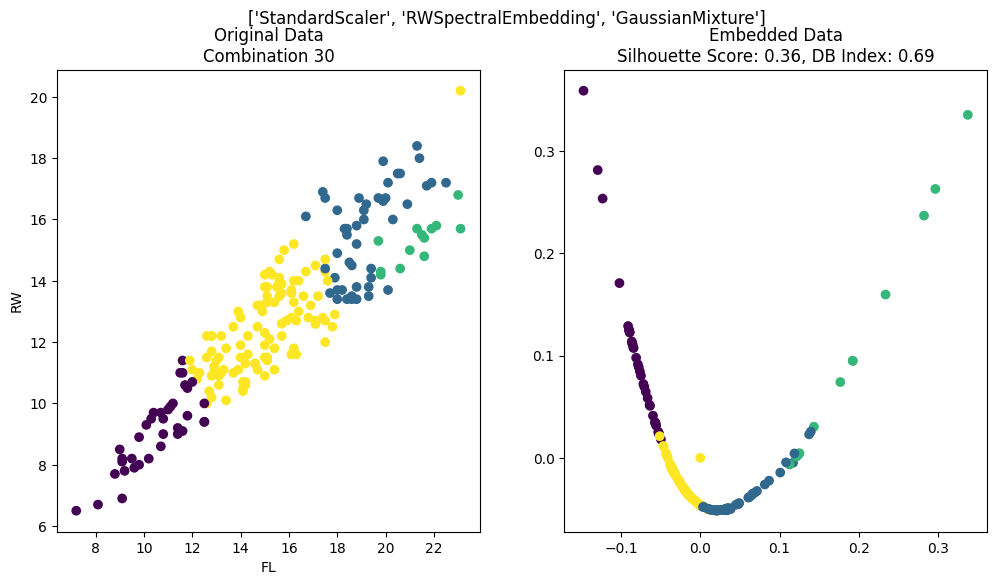

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': RWSpectralEmbedding(n_components=2), 'standardize': False}
adjusted_rand_score=0.016822478988662286 adjusted_mutual_info_score=0.05253103886757826


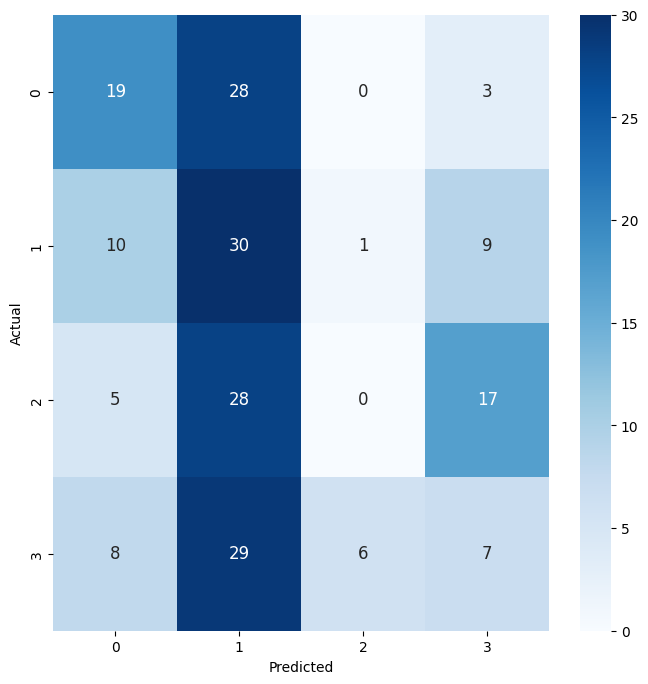

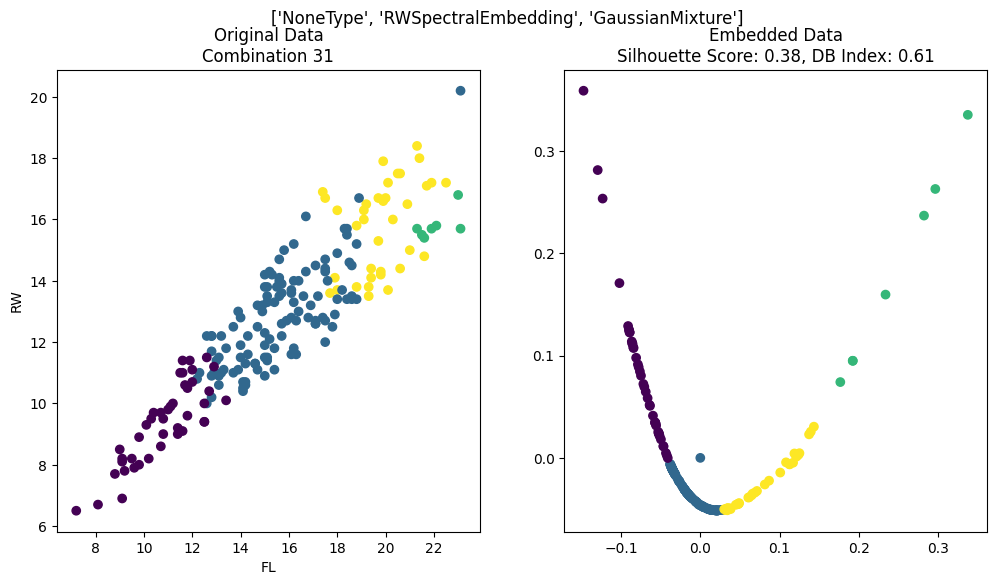

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': True}
adjusted_rand_score=0.07048741783729626 adjusted_mutual_info_score=0.07658947710491856


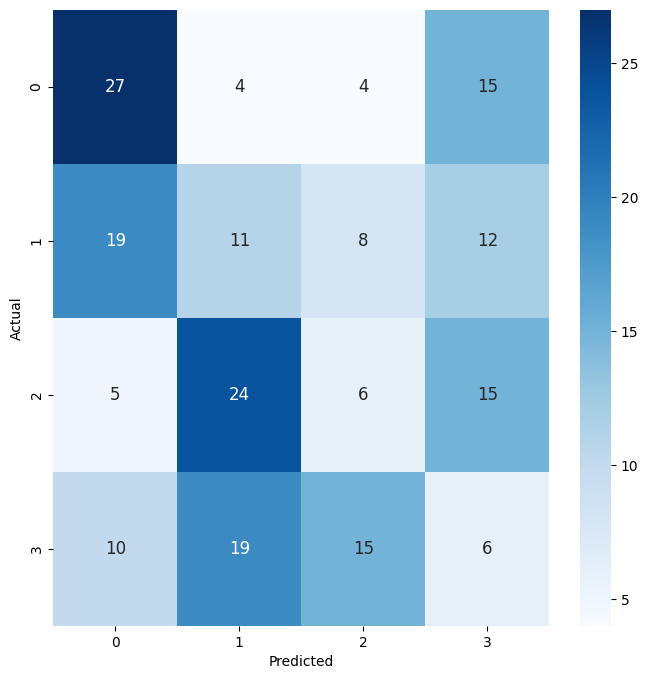

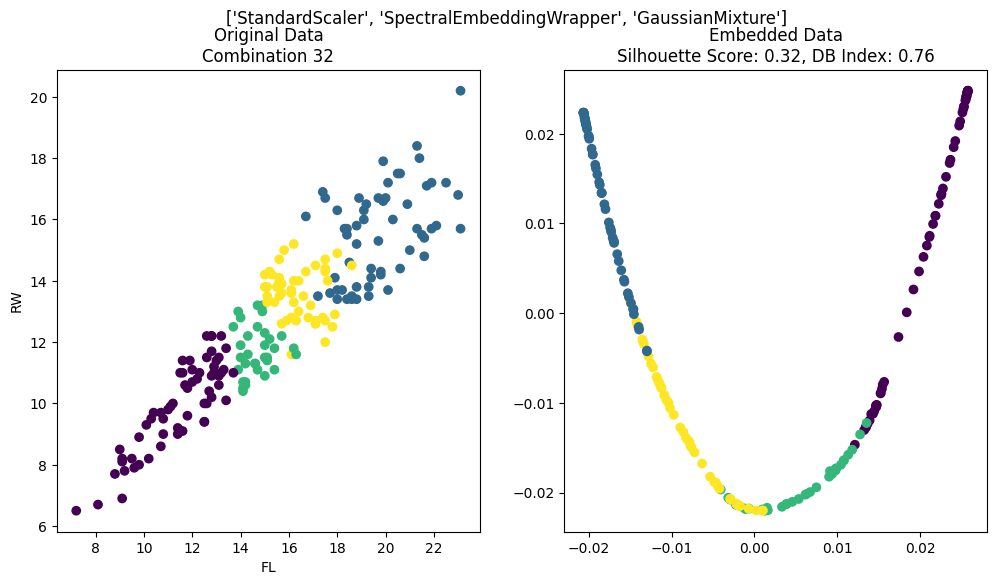

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': SpectralEmbeddingWrapper(), 'standardize': False}
adjusted_rand_score=0.040007868101534866 adjusted_mutual_info_score=0.04142320070606545


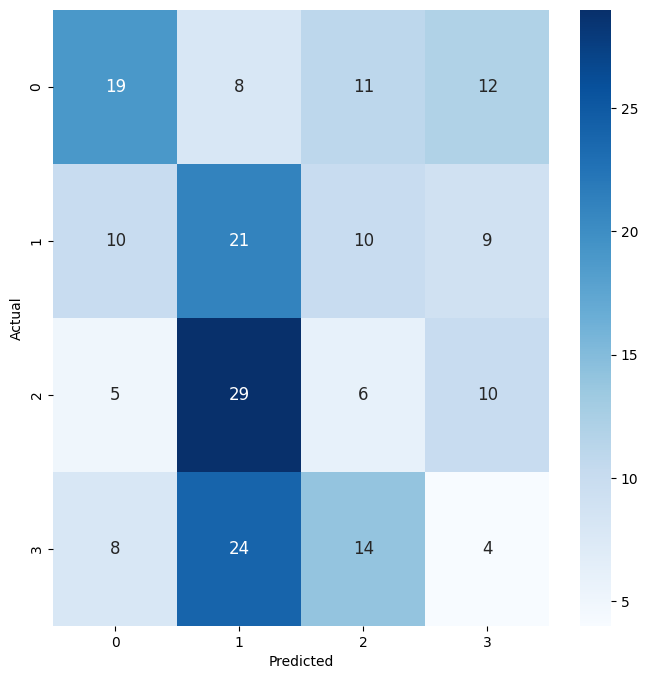

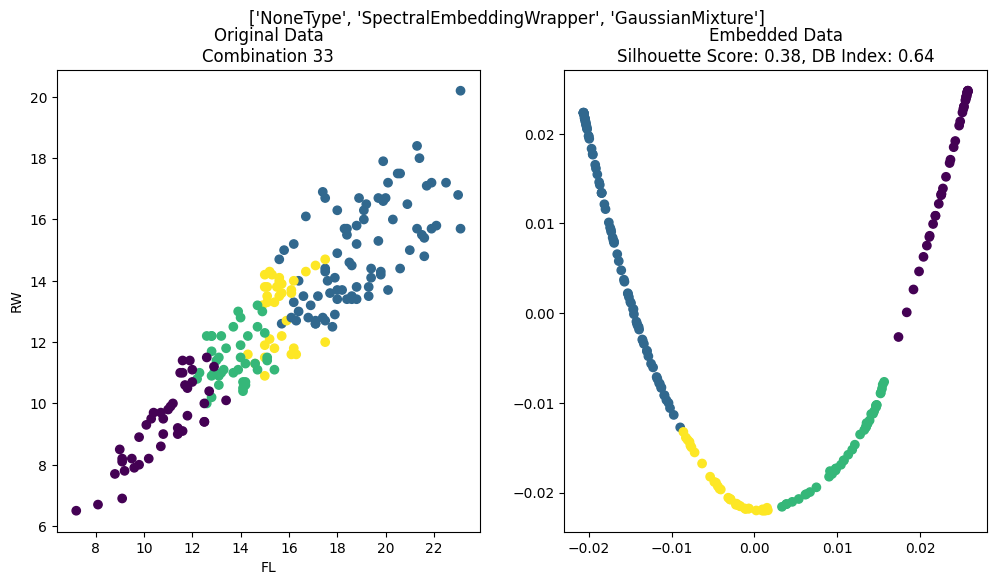

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), 'standardize': True}
adjusted_rand_score=0.06455935362064165 adjusted_mutual_info_score=0.06618030442449252


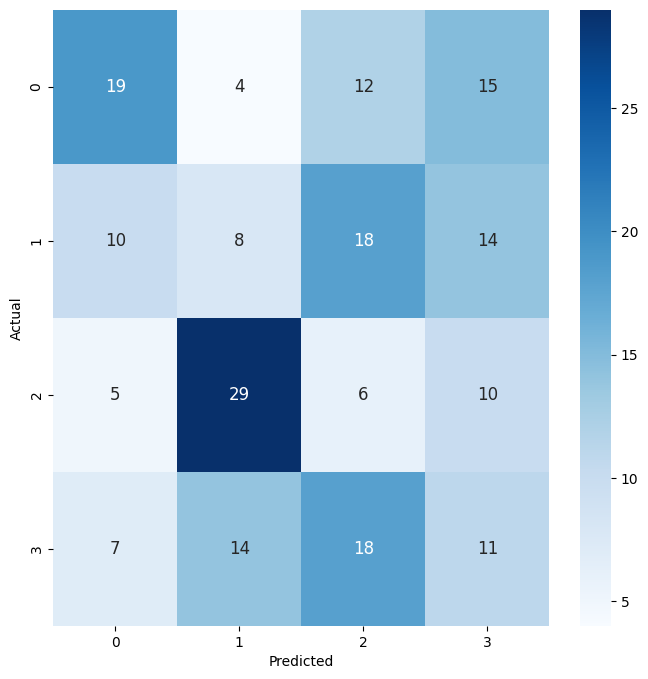

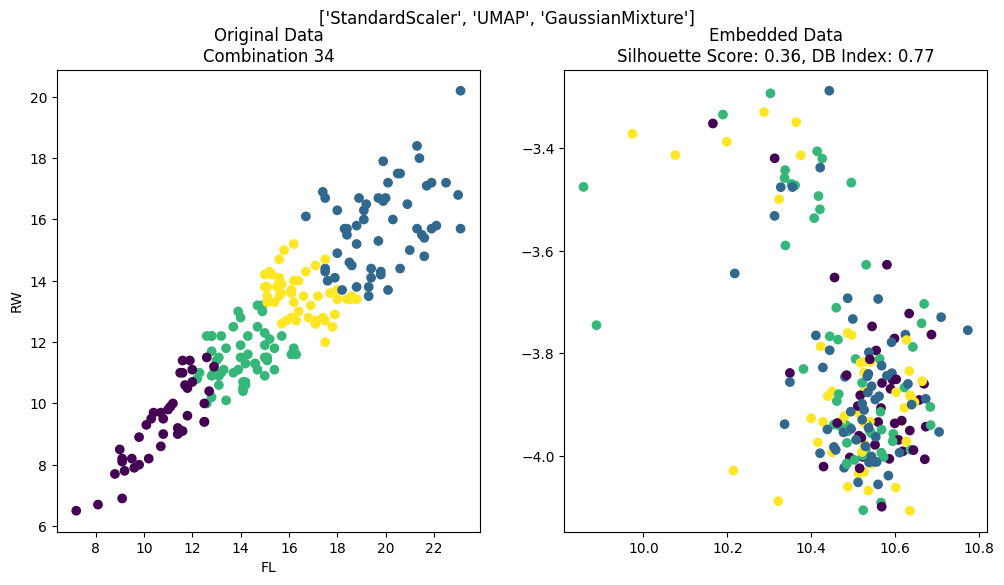

{'cluster': GaussianMixture(n_components=4, random_state=42), 'reduce_dim': UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), 'standardize': False}
adjusted_rand_score=0.05792796040772181 adjusted_mutual_info_score=0.06399548360117001


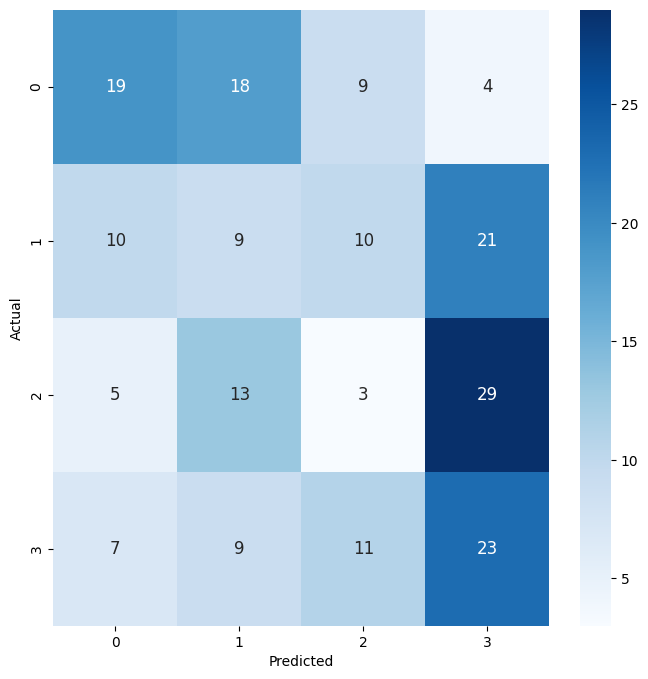

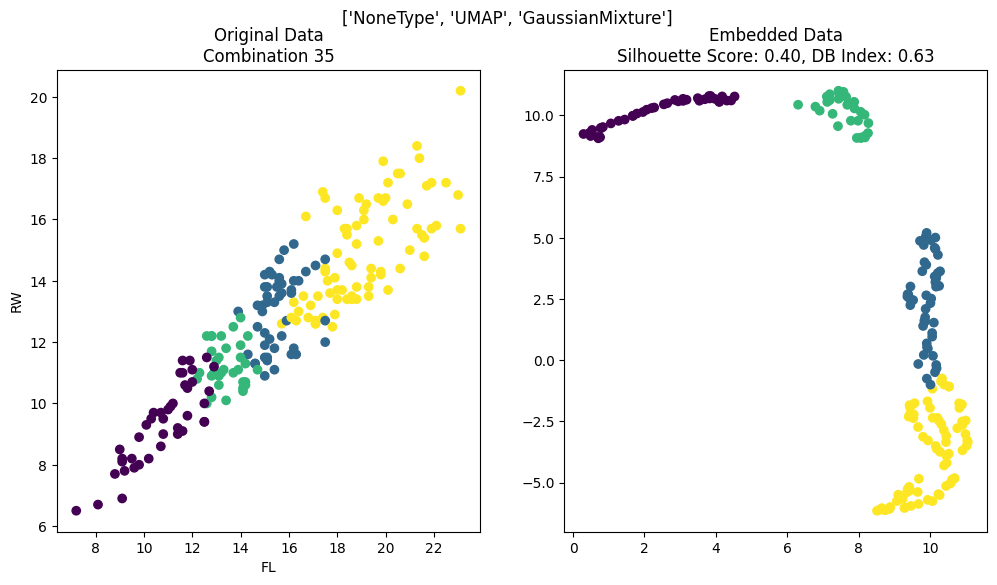

In [50]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import jax.numpy as jnp
from jax import jit
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture, decomposition, metrics, manifold, preprocessing
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Wrappers to work with Pipeline
class DBSCANWrapper(cluster.DBSCAN):
    def predict(self,X):
      return self.labels_.astype(int)


class RWSpectralEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=0.1, n_components=4):
        self.epsilon = epsilon
        self.n_components = n_components

    def fit(self, X, y=None):
        return self

    def create_laplacian(self, x):
        data = jnp.asarray(x)
        # Euclidean distances
        distances = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)
        # Epsilon similarity, based on 10% quantile
        epsilon_value = jnp.quantile(jnp.ravel(distances), q=self.epsilon)
        similarity = (distances <= epsilon_value).astype('float64')
        # Laplacian
        degrees = jnp.diag(similarity.sum(axis=0))
        laplacian = degrees - similarity
        laplacian_random_walk = jnp.diag(1 / jnp.diag(degrees)) @ laplacian
        # Laplacian eigen-decomposition
        lambdas, eigen_vectors = np.linalg.eig(laplacian)

        # Selection of eigen-vectors
        # - Exclude context eigen-vectors with zero eigen-value (can be only first or more)
        sorted_indices = np.argsort(np.abs(lambdas))
        eps = 1e-10
        non_zero_indices = sorted_indices[np.abs(lambdas[sorted_indices]) > eps]

        selected_features = np.real(eigen_vectors[:, non_zero_indices[:self.n_components+1]])

        return selected_features

    def transform(self, X):
        return self.create_laplacian(X)

# Wrappers to work with Pipeline
class SpectralEmbeddingWrapper(manifold.SpectralEmbedding):

    def transform(self, X):
        return self.fit_transform(X)

def pipeline_repr(pipeline):
    steps = pipeline.steps
    return str(list(map(lambda x : type(x[1]).__name__, steps)))

REDUCE_DIM = "reduce_dim"
CLUSTER = "cluster"

def create_pipeline(standardize=True, reduce_dim=None, cluster=None):
    steps = []

    if standardize:
        steps.append(('standardize', StandardScaler()))

    if reduce_dim:
        steps.append((REDUCE_DIM, reduce_dim))

    if cluster:
        steps.append((CLUSTER, cluster))

    return Pipeline(steps)


from sklearn.model_selection import ParameterGrid

n_clusters = 4
random_state = 42

param_grid = {
    "standardize": [True, False],
    "reduce_dim": [
        None,
        decomposition.PCA(n_components=2),
        decomposition.PCA(n_components=3, svd_solver="full"),
        RWSpectralEmbedding(n_components=2),
        SpectralEmbeddingWrapper(n_components=2),
        umap.UMAP()
    ],
    CLUSTER: [
        cluster.KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state),
        DBSCANWrapper(eps=0.3),
        mixture.GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=random_state)
    ]
}

X = crabs.drop(columns=["sp", "sex", "index"])
y_true = preprocessing.LabelEncoder().fit_transform(crabs["sp"] + crabs["sex"])

results = []

def pipeline_repr(pipeline):
    steps = pipeline.steps
    return str(list(map(lambda x : type(x[1]).__name__, steps)))

for i, combination in enumerate(ParameterGrid(param_grid)):
    pipeline = create_pipeline(**combination)
    print(combination)

    result = {}
    combination_repr = []
    for step in ["standardize", REDUCE_DIM, CLUSTER]:
        _repr = type(pipeline.named_steps.get(step, None)).__name__
        result[step] = _repr
        combination_repr.append(_repr)

    pipeline.fit(X)

    y_pred = pipeline.predict(X)

    if y_true is not None:
        adjusted_rand_score = metrics.adjusted_rand_score(y_true, y_pred)
        adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y_true, y_pred)
        print(f"{adjusted_rand_score=} {adjusted_mutual_info_score=}")

        result["adjusted_rand_score"] = adjusted_rand_score
        result["adjusted_mutual_info_score"] = adjusted_mutual_info_score

        data = metrics.confusion_matrix(y_true, y_pred)
        classes = range(len(data))

        df_cm = pd.DataFrame(data, columns=classes, index=classes)
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        plt.figure(figsize = (8,8))
        sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 12})
        plt.plot()

    # Calculate clustering metrics on the original data
    if len(np.unique(y_pred)) > 1:
        silhouette_avg = metrics.silhouette_score(X, y_pred)
        davies_bouldin_avg = metrics.davies_bouldin_score(X, y_pred)
        result["silhouette_avg"] = silhouette_avg
        result["davies_bouldin_avg"] = davies_bouldin_avg
    else:
        silhouette_avg = 0
        davies_bouldin_avg = 0
    results.append(result)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original data scatter plot

    plt.suptitle(f"{combination_repr}")

    axs[0].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred, cmap='viridis')
    axs[0].set_title(f'Original Data\nCombination {i}')
    axs[0].set_xlabel(X.columns[0])
    axs[0].set_ylabel(X.columns[1])

    if 'reduce_dim' in pipeline.named_steps and hasattr(pipeline.named_steps['reduce_dim'], 'transform'):
        X_embedded = pipeline.named_steps['reduce_dim'].transform(X)

        # Embedded data scatter plot
        axs[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_pred, cmap='viridis')
        axs[1].set_title(f'Embedded Data\nSilhouette Score: {silhouette_avg:.2f}, DB Index: {davies_bouldin_avg:.2f}')

    plt.show()



In [51]:
df_results = pd.DataFrame(results)
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

df_results.style.apply(
    highlight_max,
    props='color:white;background-color:darkblue',
    axis=0,
    subset=(df_results.index, df_results.select_dtypes(float).columns)
).apply(
    highlight_min,
    props='color:white;background-color:darkred',
    axis=0,
    subset=(df_results.index, df_results.select_dtypes(float).columns)
).format(
    formatter={col: "{:.2f}".format for col in df_results.select_dtypes(float).columns}
)


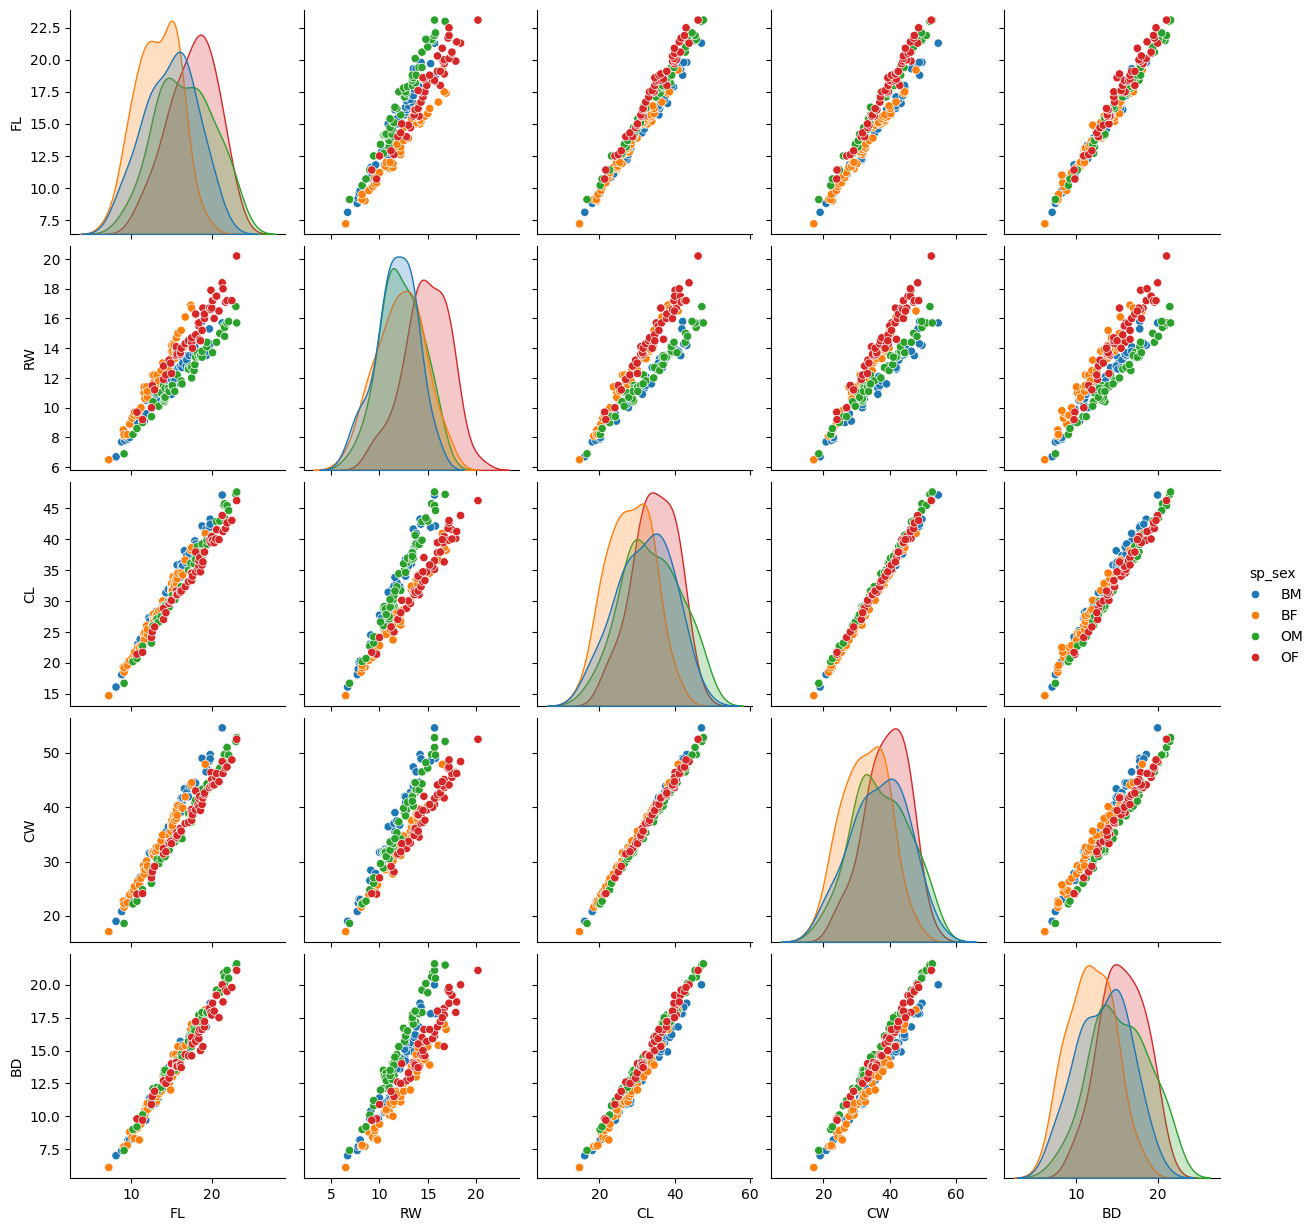

In [76]:
import seaborn as sns
crabs_plot = crabs.copy().drop(columns=["index"])
crabs_plot["sp_sex"] = crabs_plot["sp"] + crabs_plot["sex"]
sns.pairplot(crabs_plot, hue='sp_sex');


In [26]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.laplacian.html
# https://scikit-learn.org/stable/modules/manifold.html#spectral-embedding